# Classiciation Model to Predict Whether Someone Has Blood Pressure

This worksheet is used for modeling data from the National Health & Nutrition Examination Survey between the years 2007 - 2016 with the intent of predicting whether someone between the ages of 18 - 80 has high blood pressure.</br>

Target Variable: **High Blood Pressure** (binary, yes or no)</br>

### TABLE OF CONTENTS
1. [Features](#FEATURES)
2. [Exploratory Data Analysis (EDA)](#EXPLORATORY-DATA-ANALYSIS)
3. [Modeling](#MODELING)
    - [Logistic Rergression - version 1](#Logistic-Regression-Model-v1) (two features)
    - [Logistic Rergression - version 2](#Logistic-Regression-Model-v2) (5 features)
    - [Logistic Regression w/Oversampling](#Logistic-Regression-With-Oversampling-Model) (5 features)
    - [Decision Tree](#Decision-Tree-Model)
    - [Random Forest](#Random-Forest-Model)
4. [Comparison of models](#COMPARISON-OF-MODELS)
5. Final selection results

-
### FEATURES 

Features that are under consideration for this model are:
1. BMI
2. Waist Circumference
3. Height
4. Weight
5. Gender
6. Age
7. Race
8. Frequency of eating out
9. Frequency of eating ready-to-eat meals
10. Frequencey of eating frozen foods
11. Whether smoked cigarettes 100 times in lifetime
12. Whether currently smokes cigarettes
13. Whether have vigorous activity at work (over 10 min avg daily)
14. Whether have moderate activity at work (over 10 min avg daily)
15. Whether bike or walk to get to and from places 10 min continously each week
16. Whether do vigorous activity for recreational activity
17. Length of time spent sitting (avg daily)
18. Whether have had more than 12 alcoholic drinks in past year
19. Number of drinks had per day on average for past year
20. Occupation status
21. If have job, number of hours worked in past week

In [201]:
# run this cell to get all libraries & modules required to run this notebook


%pylab inline
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

import pickle
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import cross_val_score
GridSearchCV

from yellowbrick.model_selection import FeatureImportances

from mlxtend.plotting import plot_decision_regions

from collections import Counter

Populating the interactive namespace from numpy and matplotlib


-</br>
-</br>
### EXPLORATORY DATA ANALYSIS

-
#### Pull in cleaned dataset & create dummies
Un-pickle cleaned dataset for NHANES data (created in `data/NHANES_data_collection.ipynb`) to build model for predicting whether someone has high blood pressure (target variable) >

In [202]:
with open('data/pickles/nhanes_clean.pickle','rb') as read_file:
    nhanes_clean = pickle.load(read_file)

In [203]:
# create dummies for two oject columns: race & job status

nhanes_clean = pd.get_dummies(nhanes_clean)

In [204]:
len(nhanes_clean.columns)

29

-</br>
#### Split the data into Training, Validation, and Test Sets

In [205]:
X = nhanes_clean.drop(columns='High_Blood_Pressure')
y = nhanes_clean['High_Blood_Pressure']

In [206]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify = y)

In [207]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=.25,
                                                  random_state=42,
                                                  stratify = y_train_val
                                                 )

-</br>
#### Find the baseline high blood pressure probability
To find a 'baseline' we look at the probability of the 0/1 target for high blood pressure (1 = high blood pressure, 0 = not high blood pressure) for the y_train data.

0    0.649685
1    0.350315
Name: High_Blood_Pressure, dtype: float64


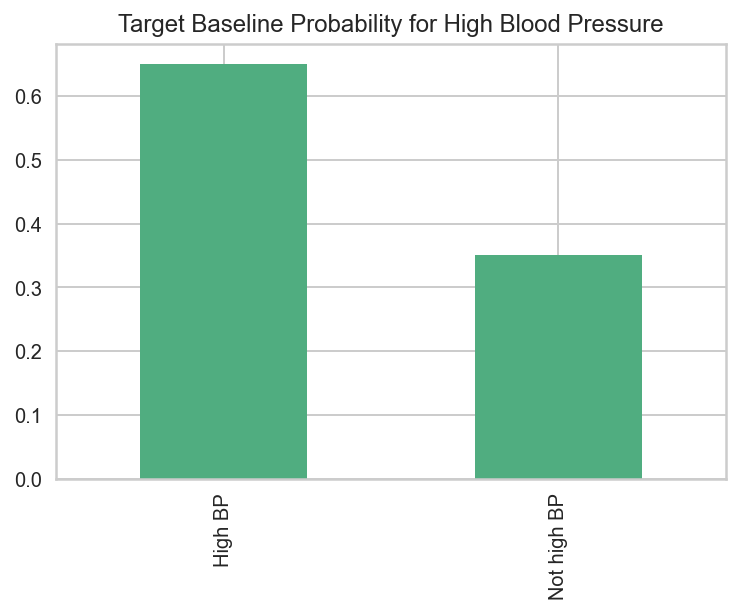

In [8]:
target_train_pcts = y_train.value_counts(normalize=True)
print(target_train_pcts)

xlabels = ['High BP', 'Not high BP']
target_train_pcts.plot(kind='bar', color='#50ad80')
plt.title('Target Baseline Probability for High Blood Pressure')
plt.xticks([0,1],xlabels);

-
#### Examine each variable's relationship to the target

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


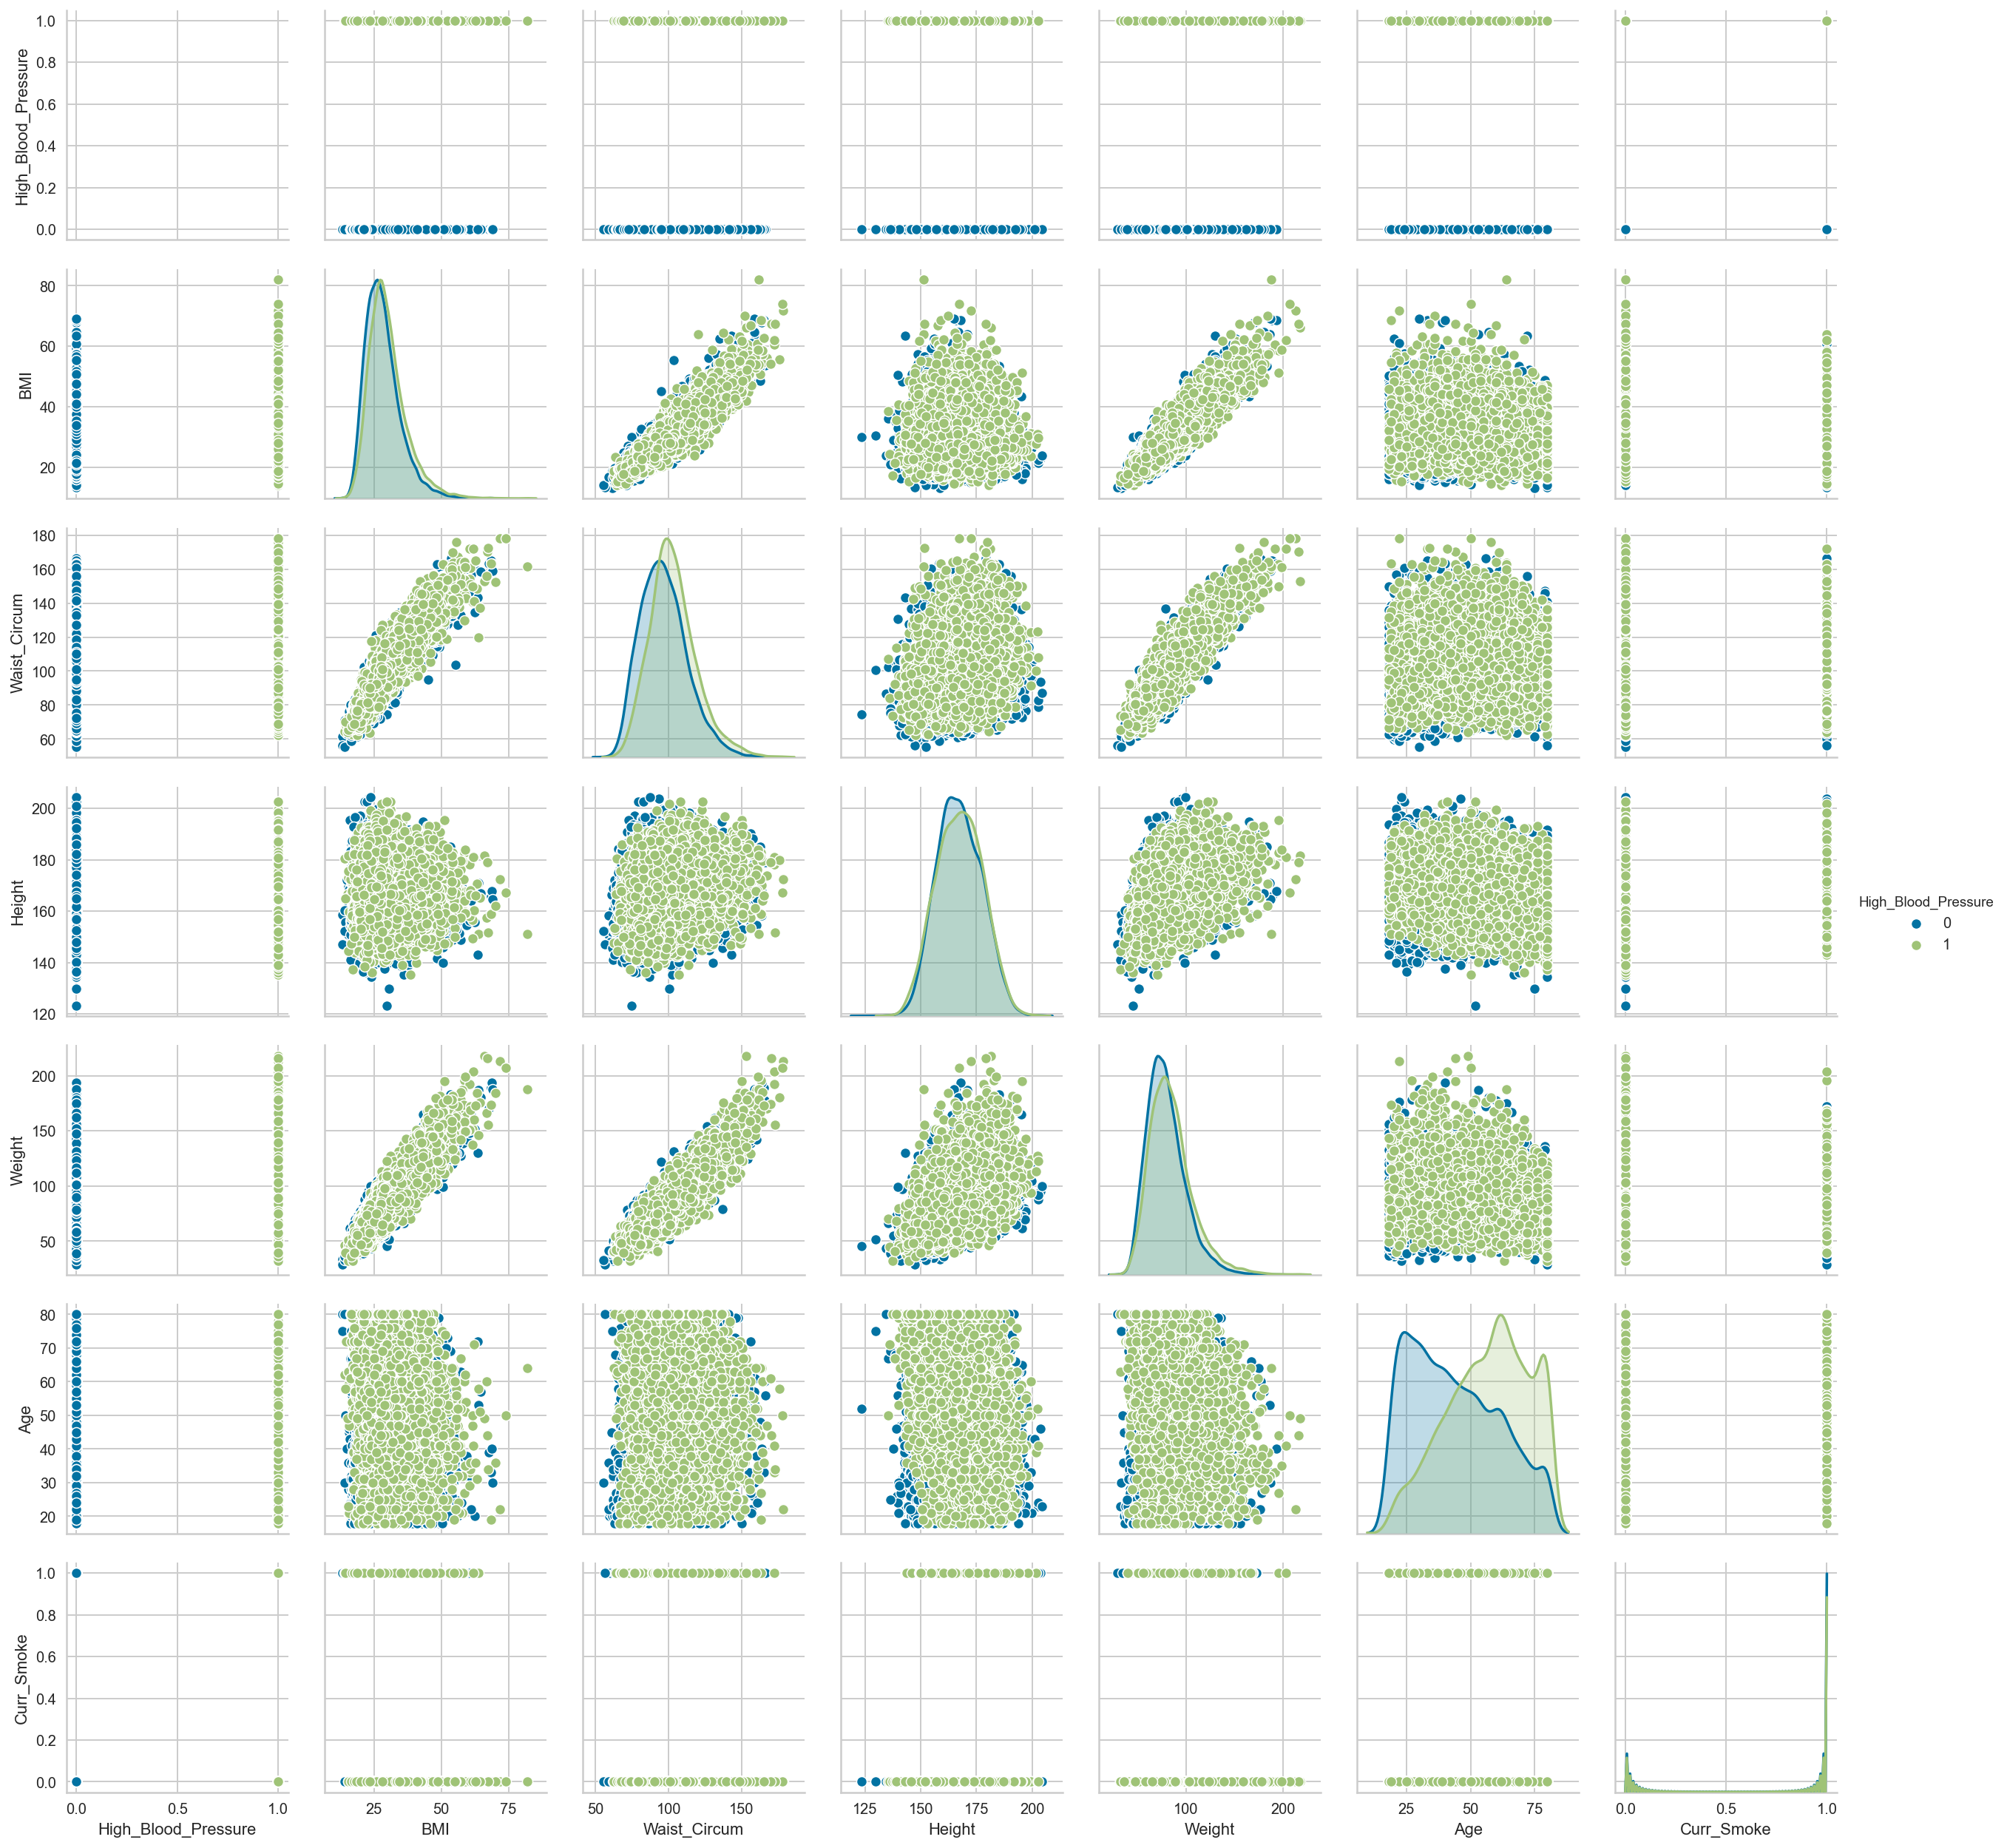

In [593]:
sns.pairplot(nhanes_clean[['High_Blood_Pressure','BMI','Waist_Circum',
                           'Height','Weight','Age','Curr_Smoke']], 
             hue='High_Blood_Pressure');

#### Takeaways:
- **AGE**: Looks like higher age may have a relationship with higher likelihood of a positive target (higher blood pressure) 
- **WAIST CIRCUMFERENCE**: Looks as though higher waist circumference size has slight indication of higher blood pressure
- Remaining features do not stand out as potential predictors

Take a closer look at the probability in buckets for features we think have relationship with high blood pressure >

In [595]:
def get_emp_prob(target='High_Blood_Pressure', column='Age', min_value=18, max_value=30):
    mask = (min_value <= nhanes_train[column]) & (nhanes_train[column] < max_value)
    return nhanes_train[mask][target].mean()

print(get_emp_prob())
print(get_emp_prob(min_value=30, max_value=50))
print(get_emp_prob(min_value=50, max_value=70))
print(get_emp_prob(min_value=70, max_value=90))

0.10563174788444704
0.27465143625062993
0.46336464560204954
0.5739257101238164


In [596]:
def get_emp_prob(target='High_Blood_Pressure', column='Waist_Circum', min_value=60, max_value=80):
    mask = (min_value <= nhanes_train[column]) & (nhanes_train[column] < max_value)
    return nhanes_train[mask][target].mean()

print(get_emp_prob())
print(get_emp_prob(min_value=80, max_value=100))
print(get_emp_prob(min_value=100, max_value=120))

0.17874632713026445
0.31313767477012217
0.41528455284552845


Indeed does indicate that Age and Waist Circumference has a relationship with blood pressure.  As each feature increases in size, so does the probability that the person will have high blood pressure


Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


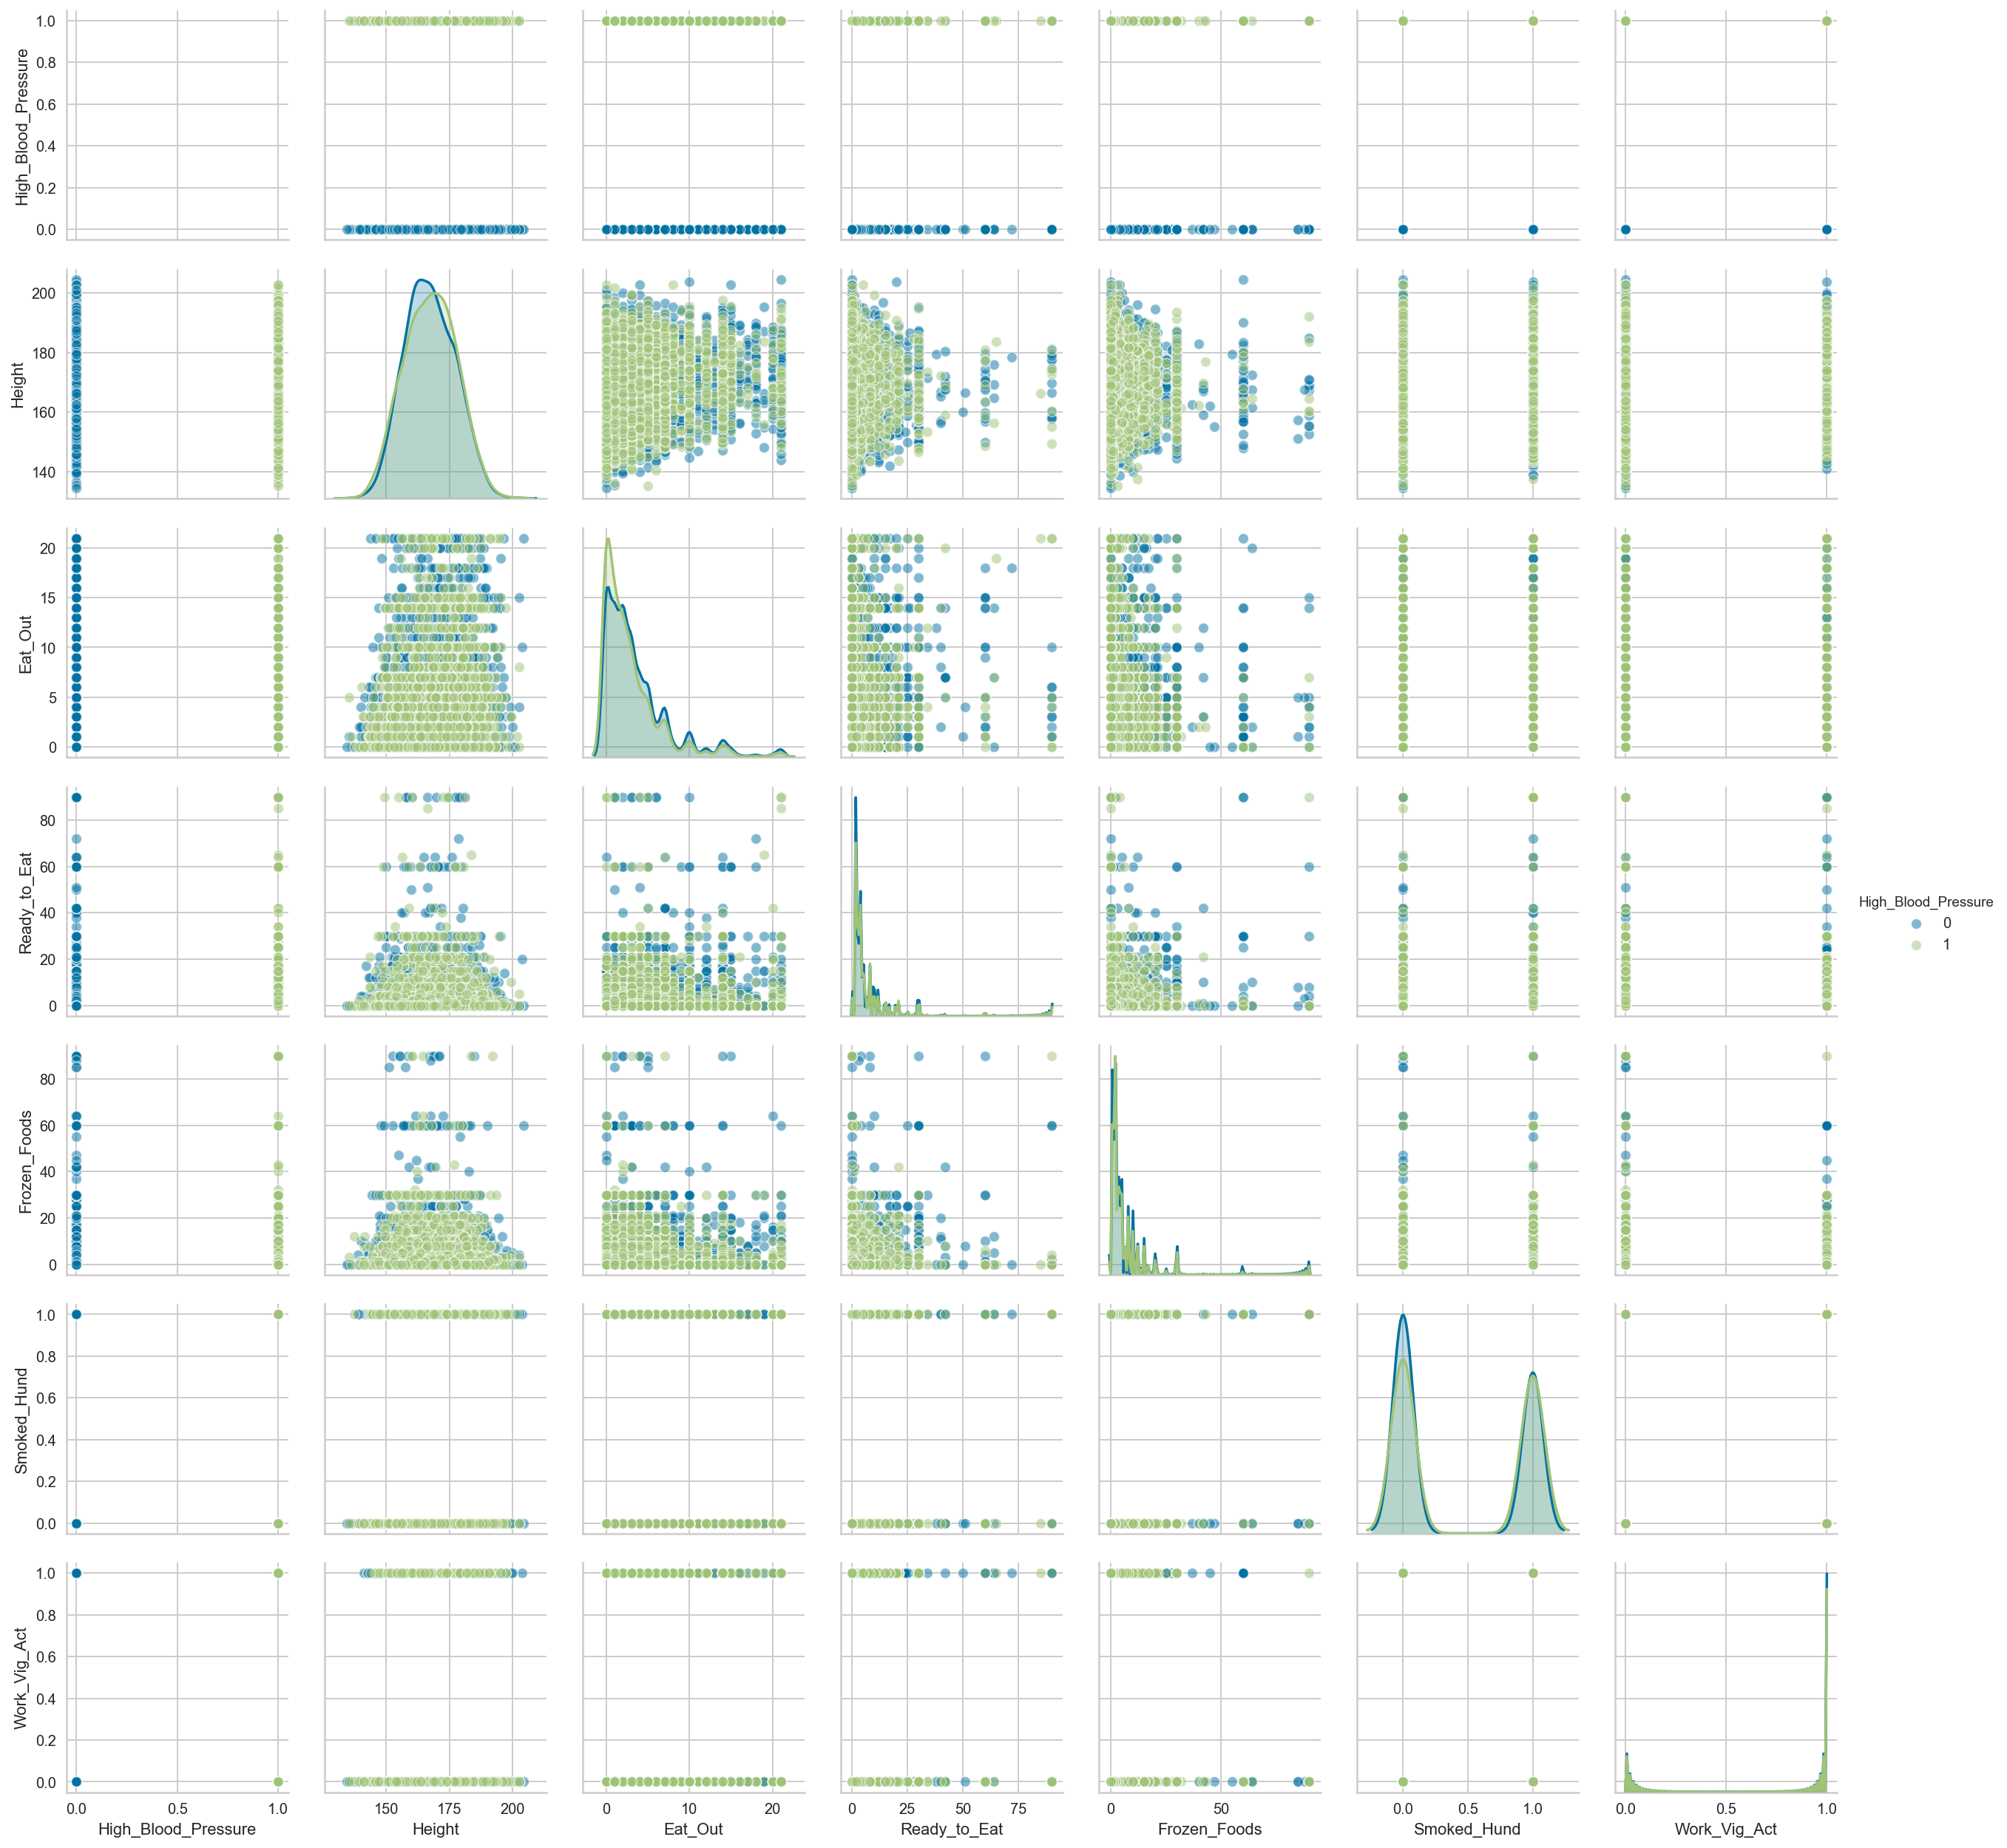

In [597]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Height','Eat_Out',
                           'Ready_to_Eat','Frozen_Foods','Smoked_Hund',
                           'Work_Vig_Act']],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- Not much standing out in these features as having relationship with high blood pressure.  Height, eating out, and frozen foods maybe slightly...

Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


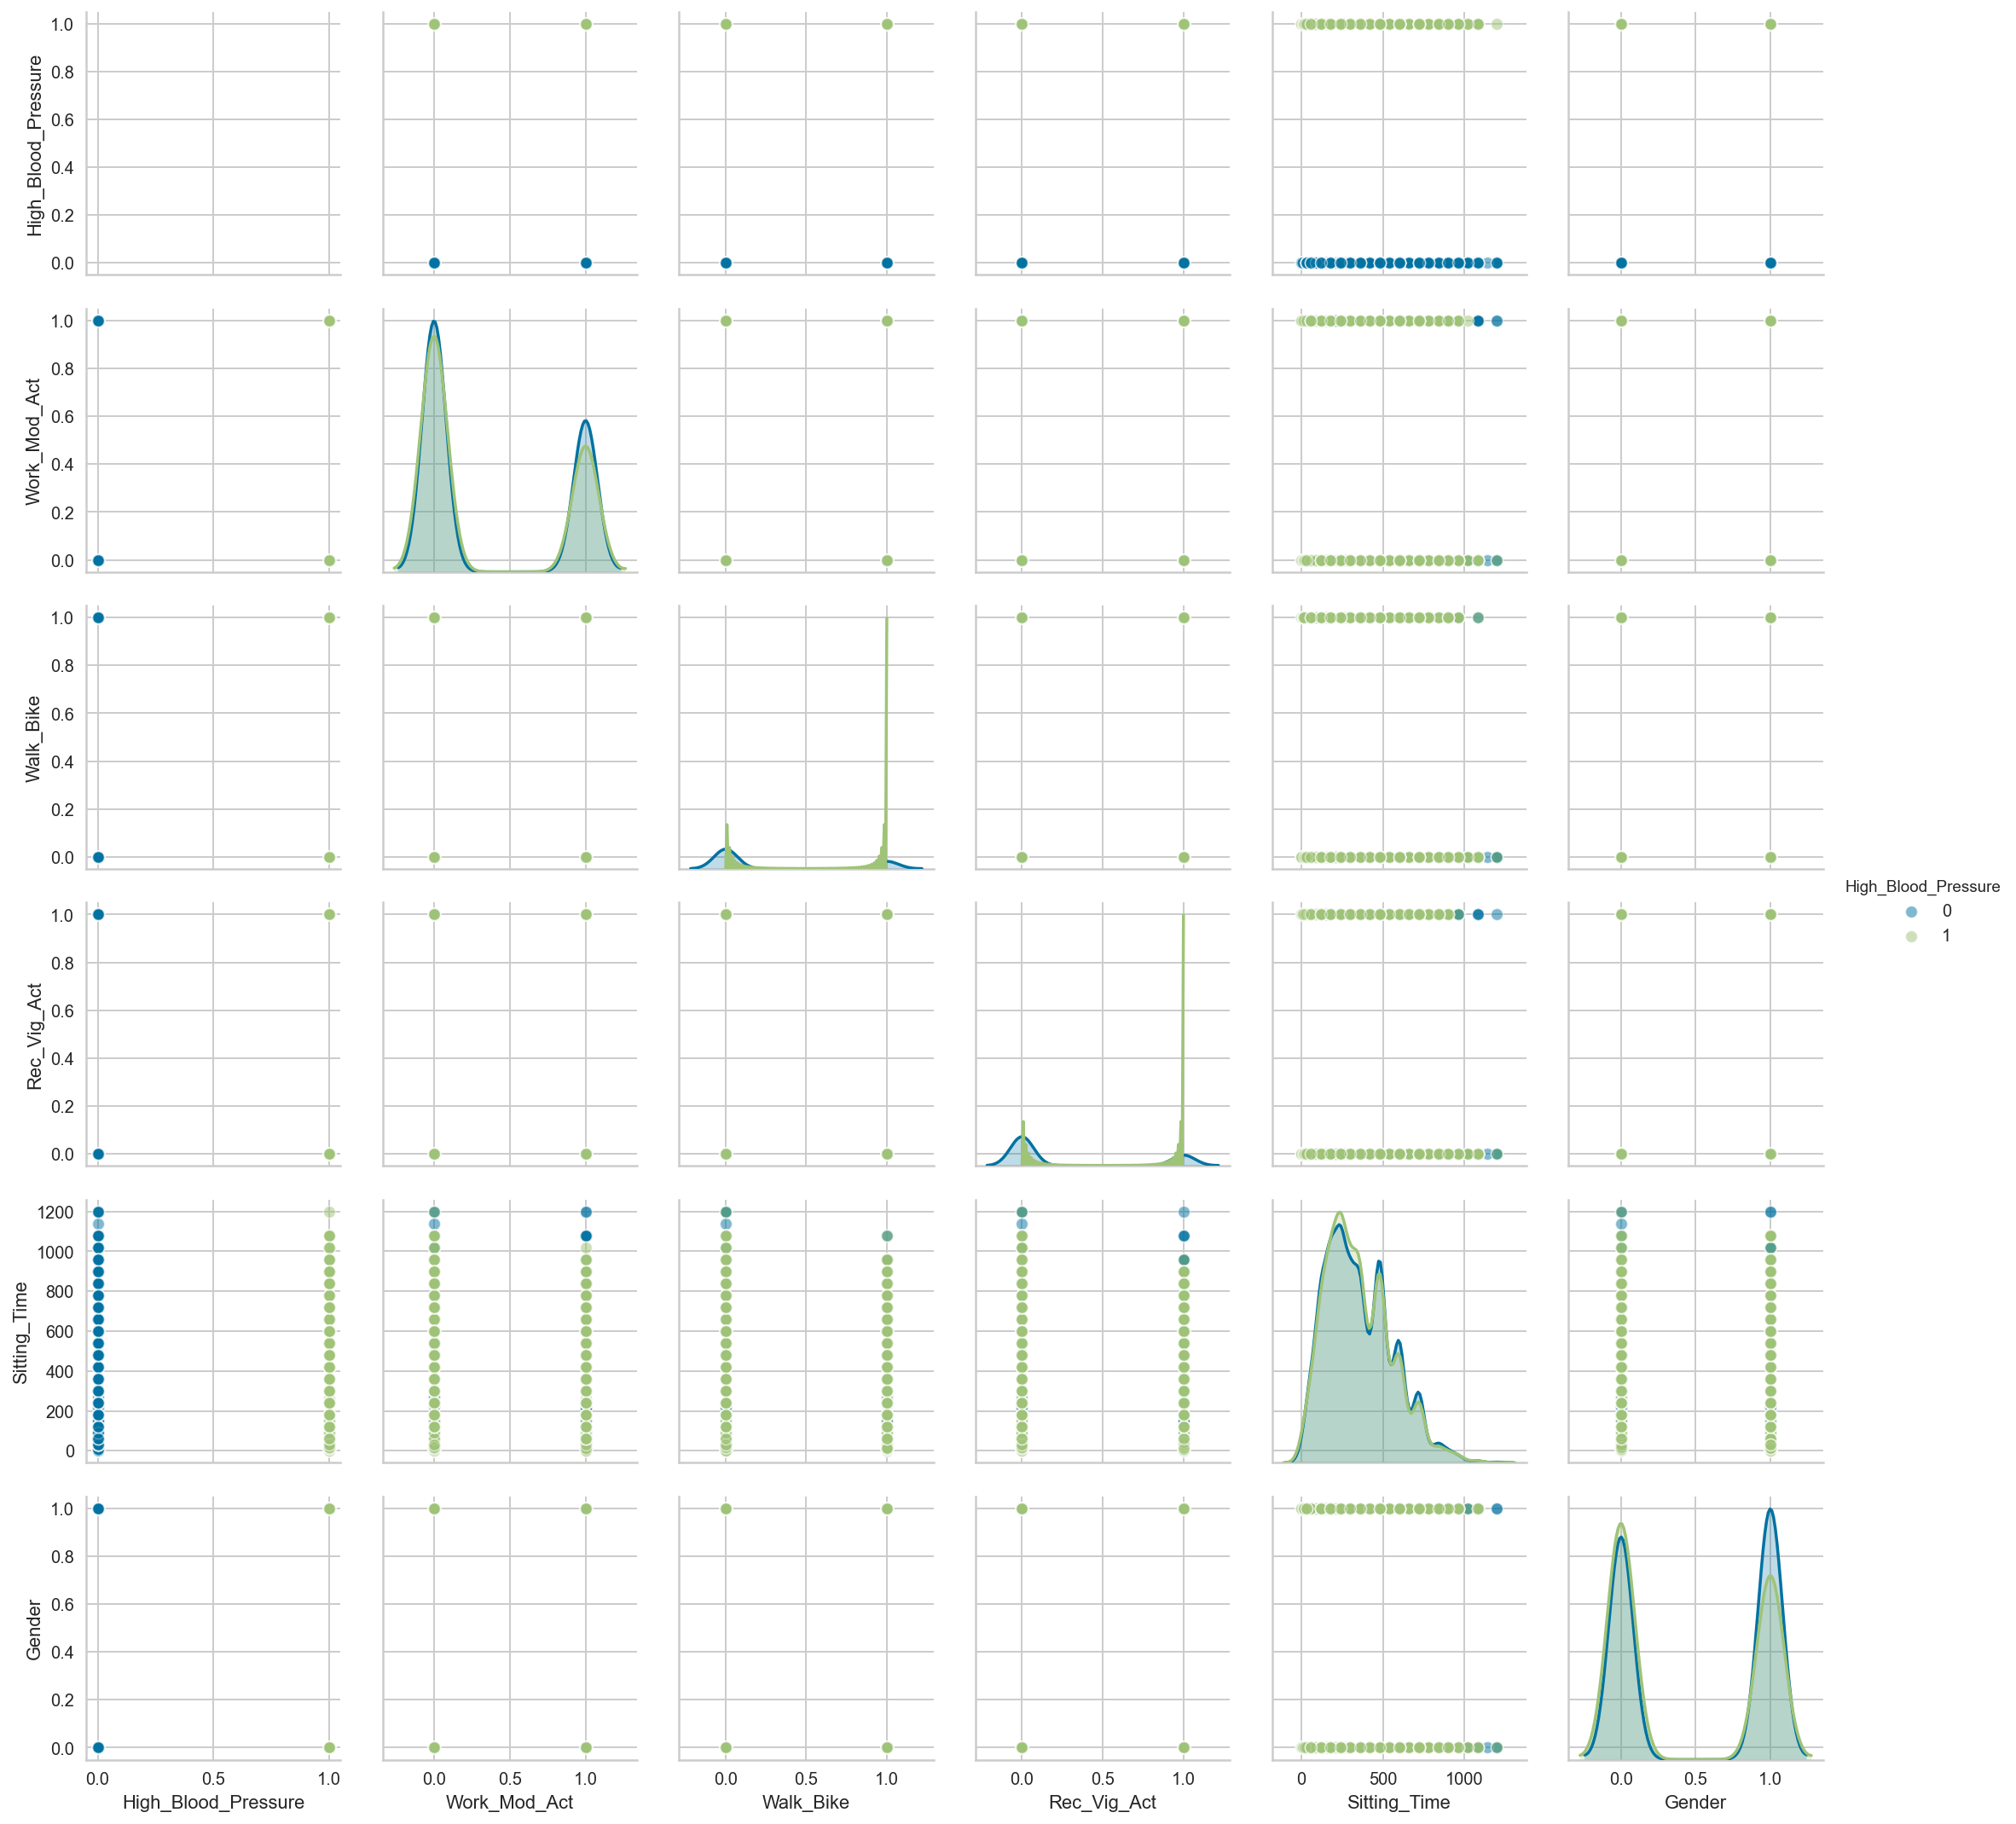

In [598]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Work_Mod_Act','Walk_Bike',
                           'Rec_Vig_Act','Sitting_Time','Gender']],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Sitting Time**: There looks like a potential slight relationship between higher sitting time and higher chance of high blood pressure
- **Walk & Biking**: May also be relationship between this and not having high blood pressure
- **Vigorous Recreational Activity**: May also be relationship between this and not having high blood pressure


Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


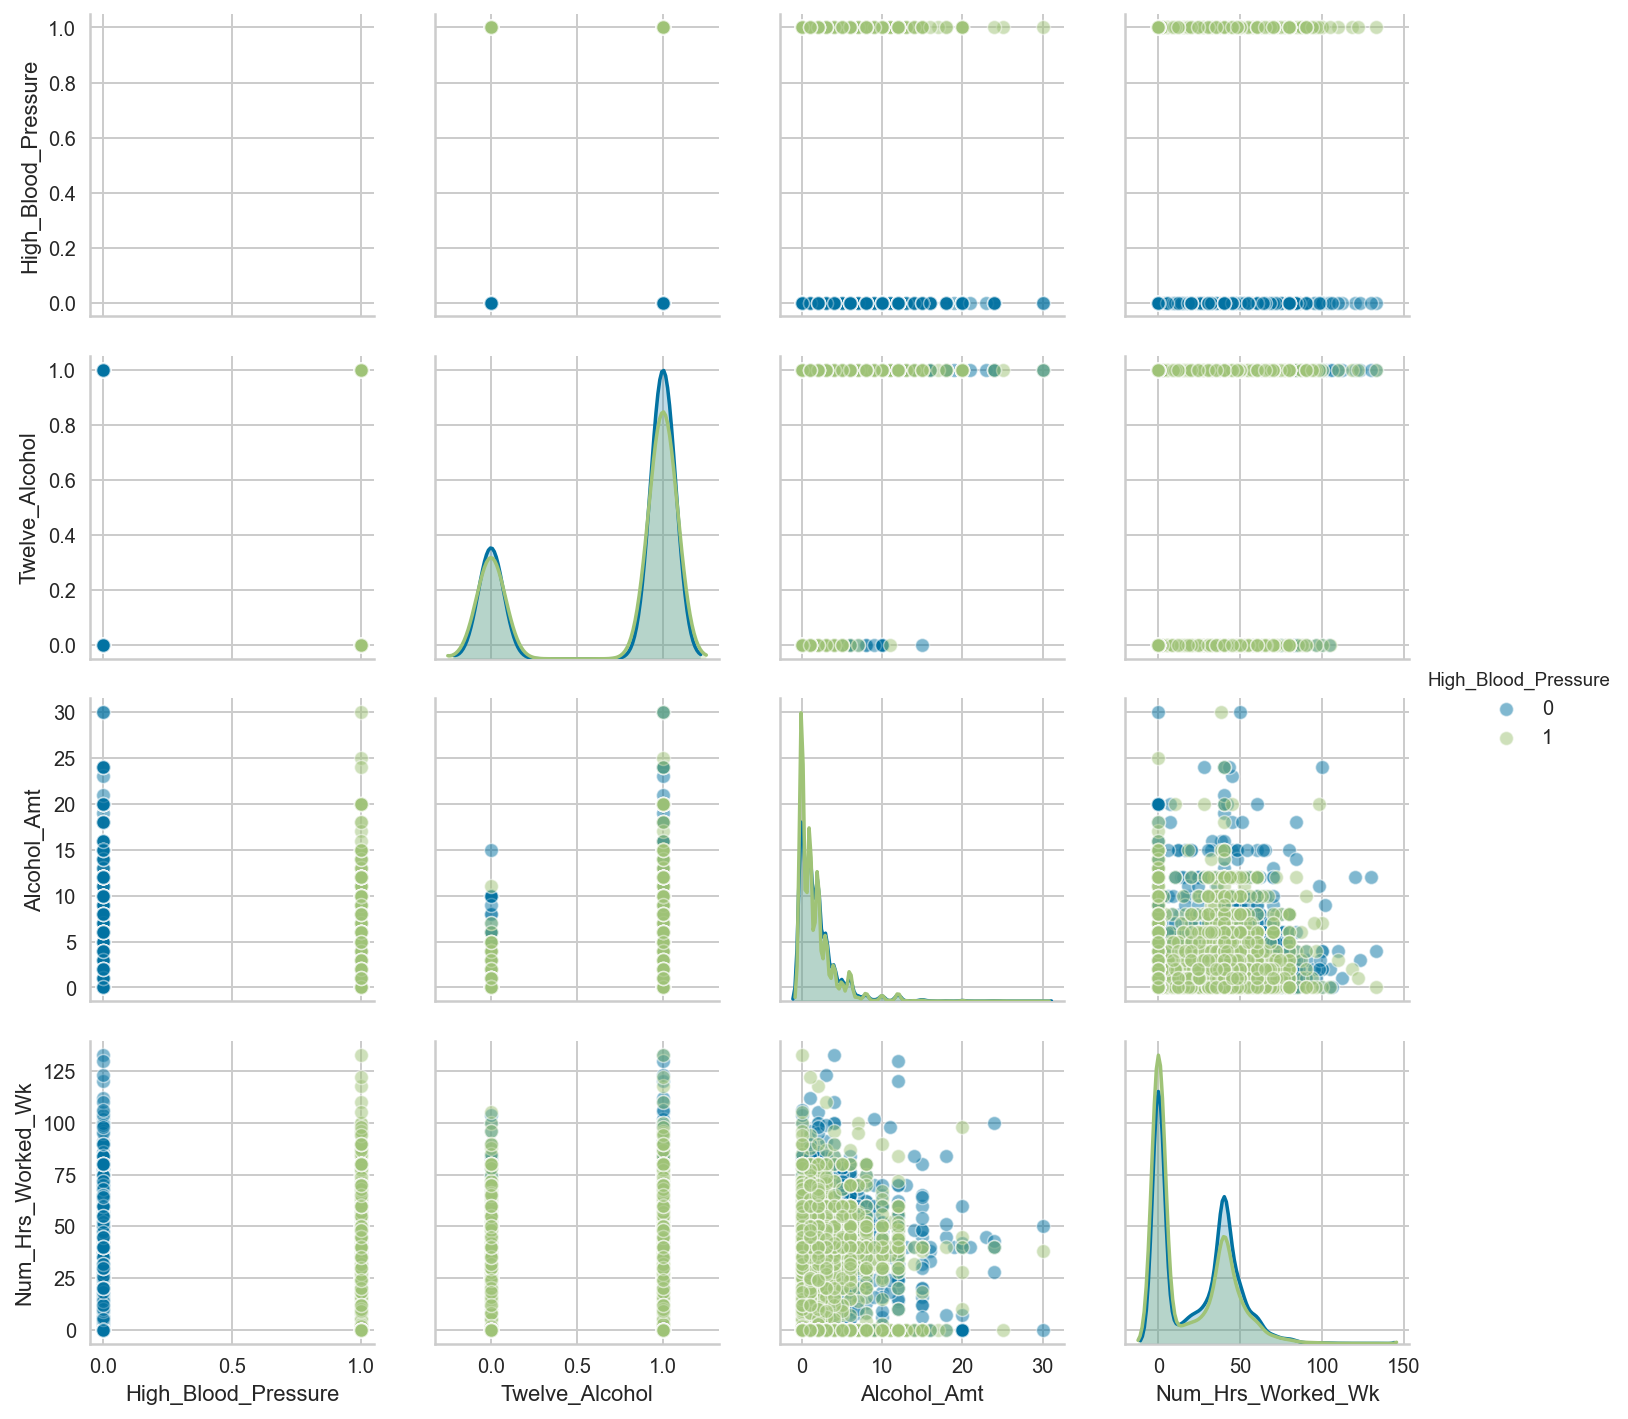

In [599]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Twelve_Alcohol',
                           'Alcohol_Amt','Num_Hrs_Worked_Wk']],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Alcohol Amount**: Hard to tell clearly from graph, but seems there is a potential relationship between drinking more alcohol and having high blood pressure

Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


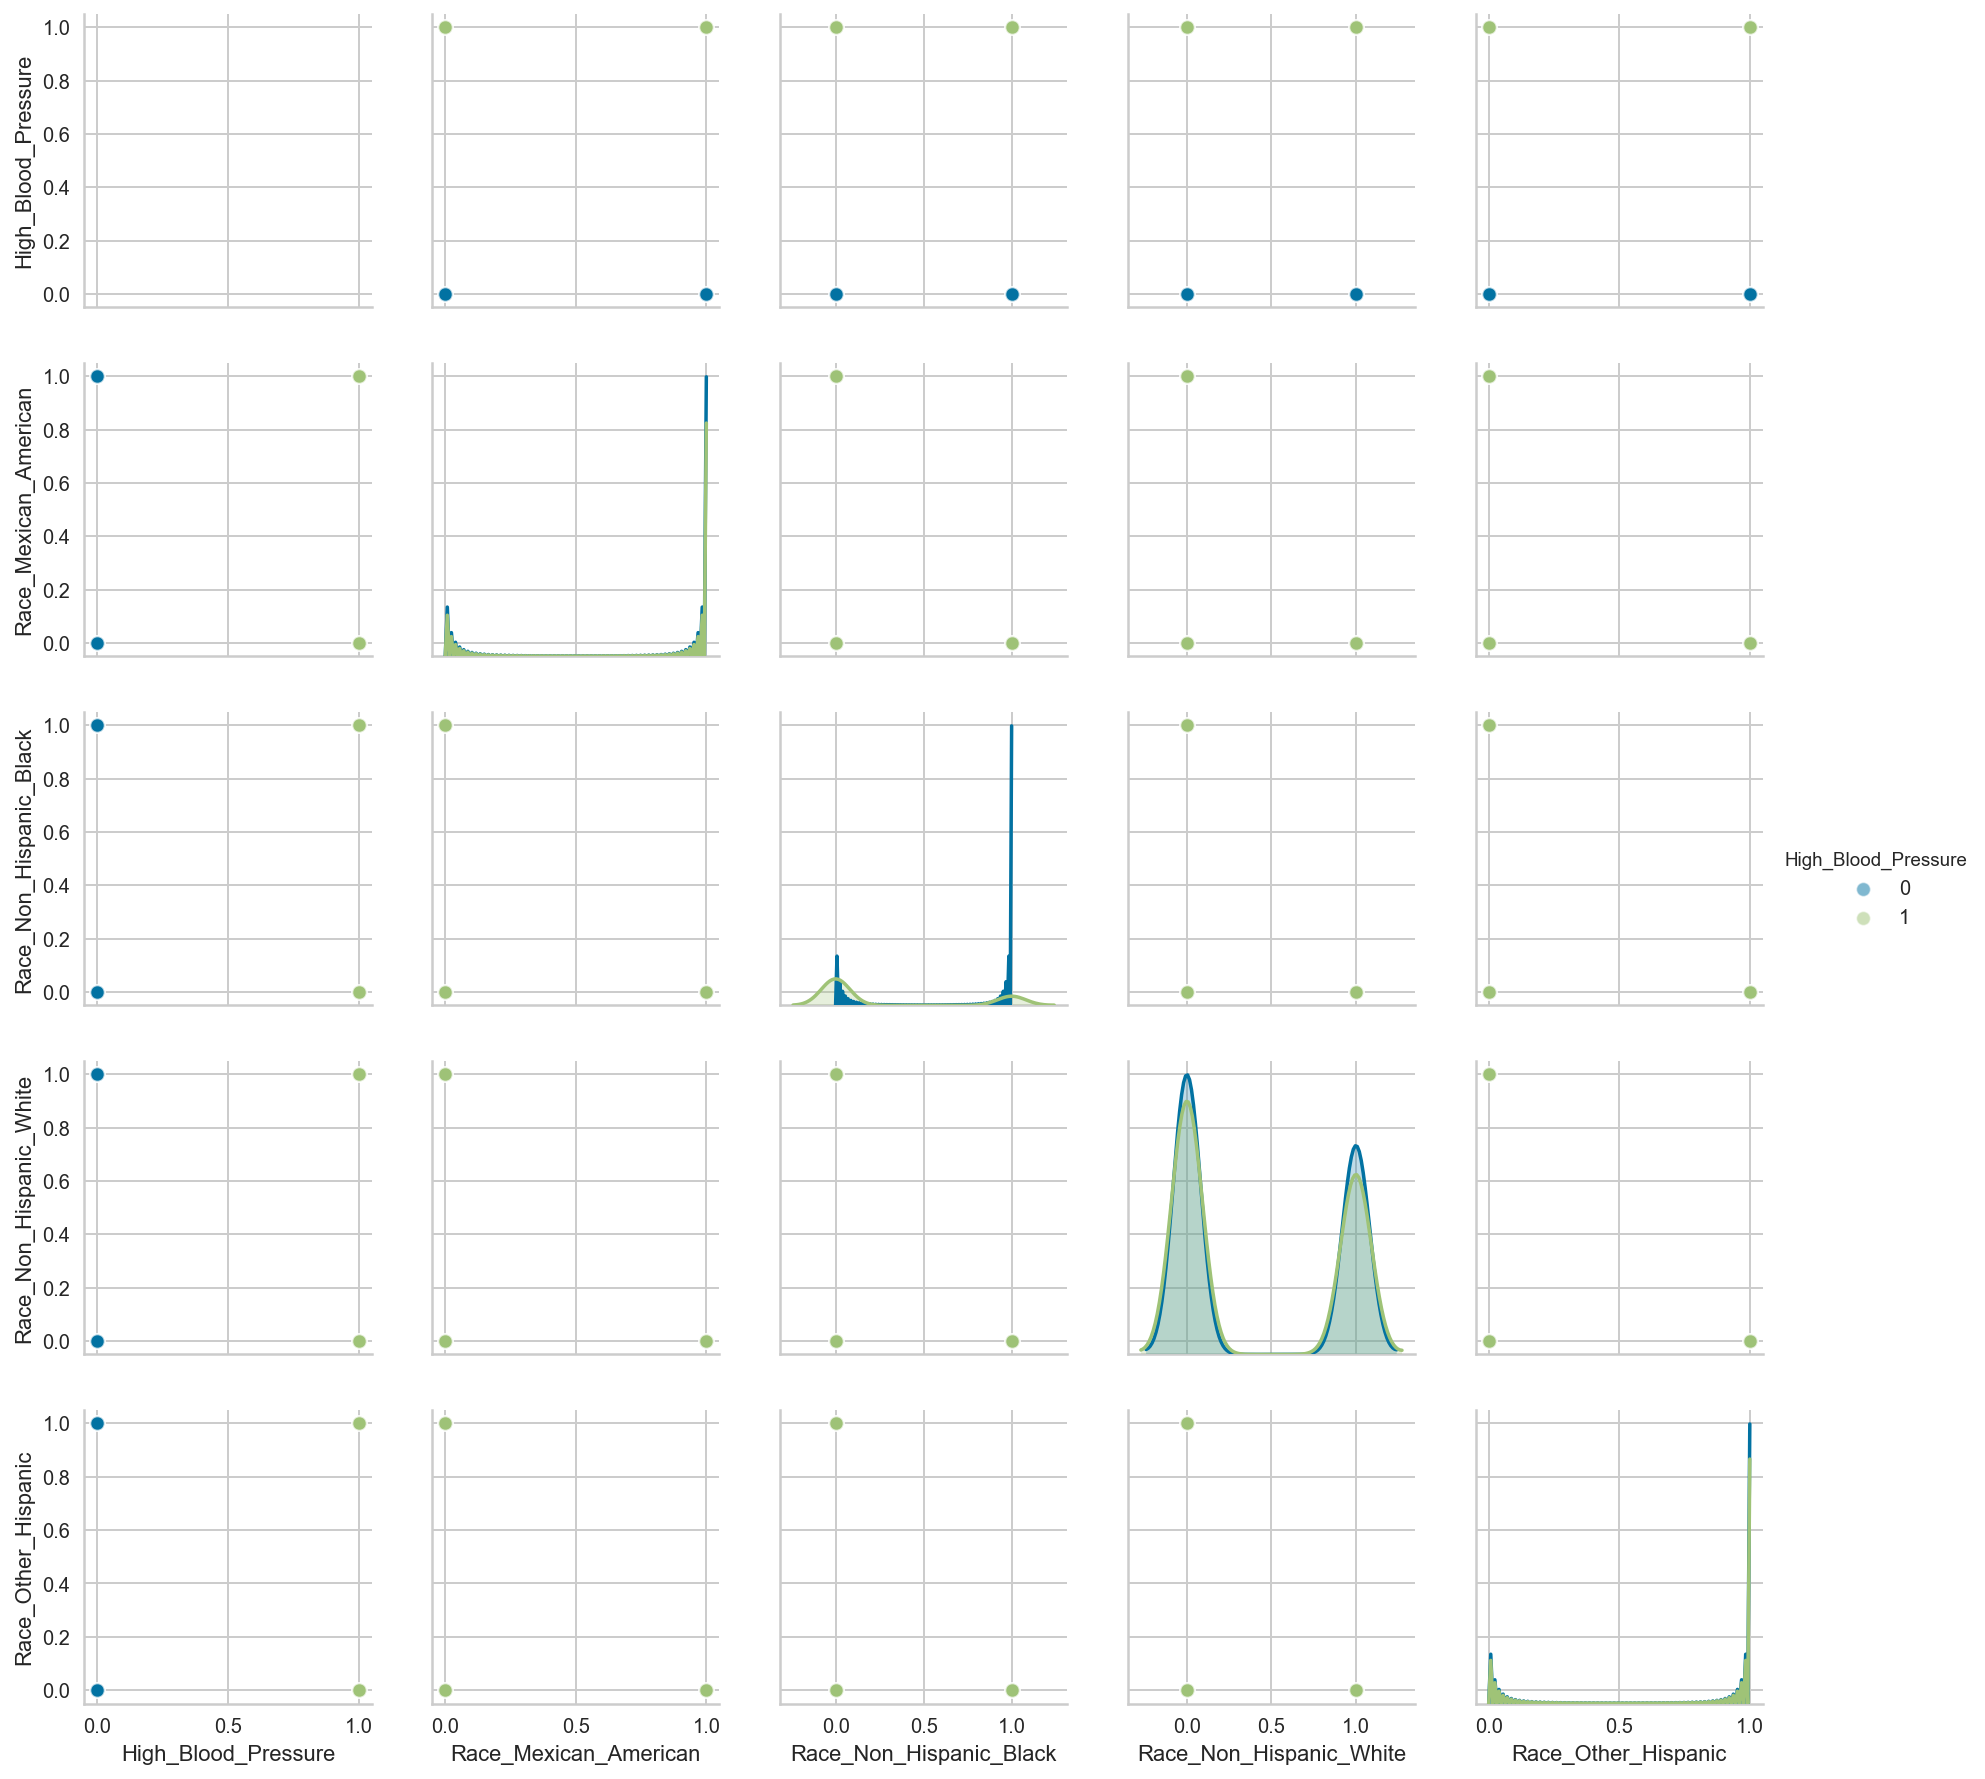

In [600]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Race_Mexican_American',
                           'Race_Non_Hispanic_Black',
                           'Race_Non_Hispanic_White','Race_Other_Hispanic'
                          ]],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- **Race - Black**: Looks like there may be a relationship between those identifying as Black and having high blood pressure

Will take a look at more features' relationships to the target >

/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


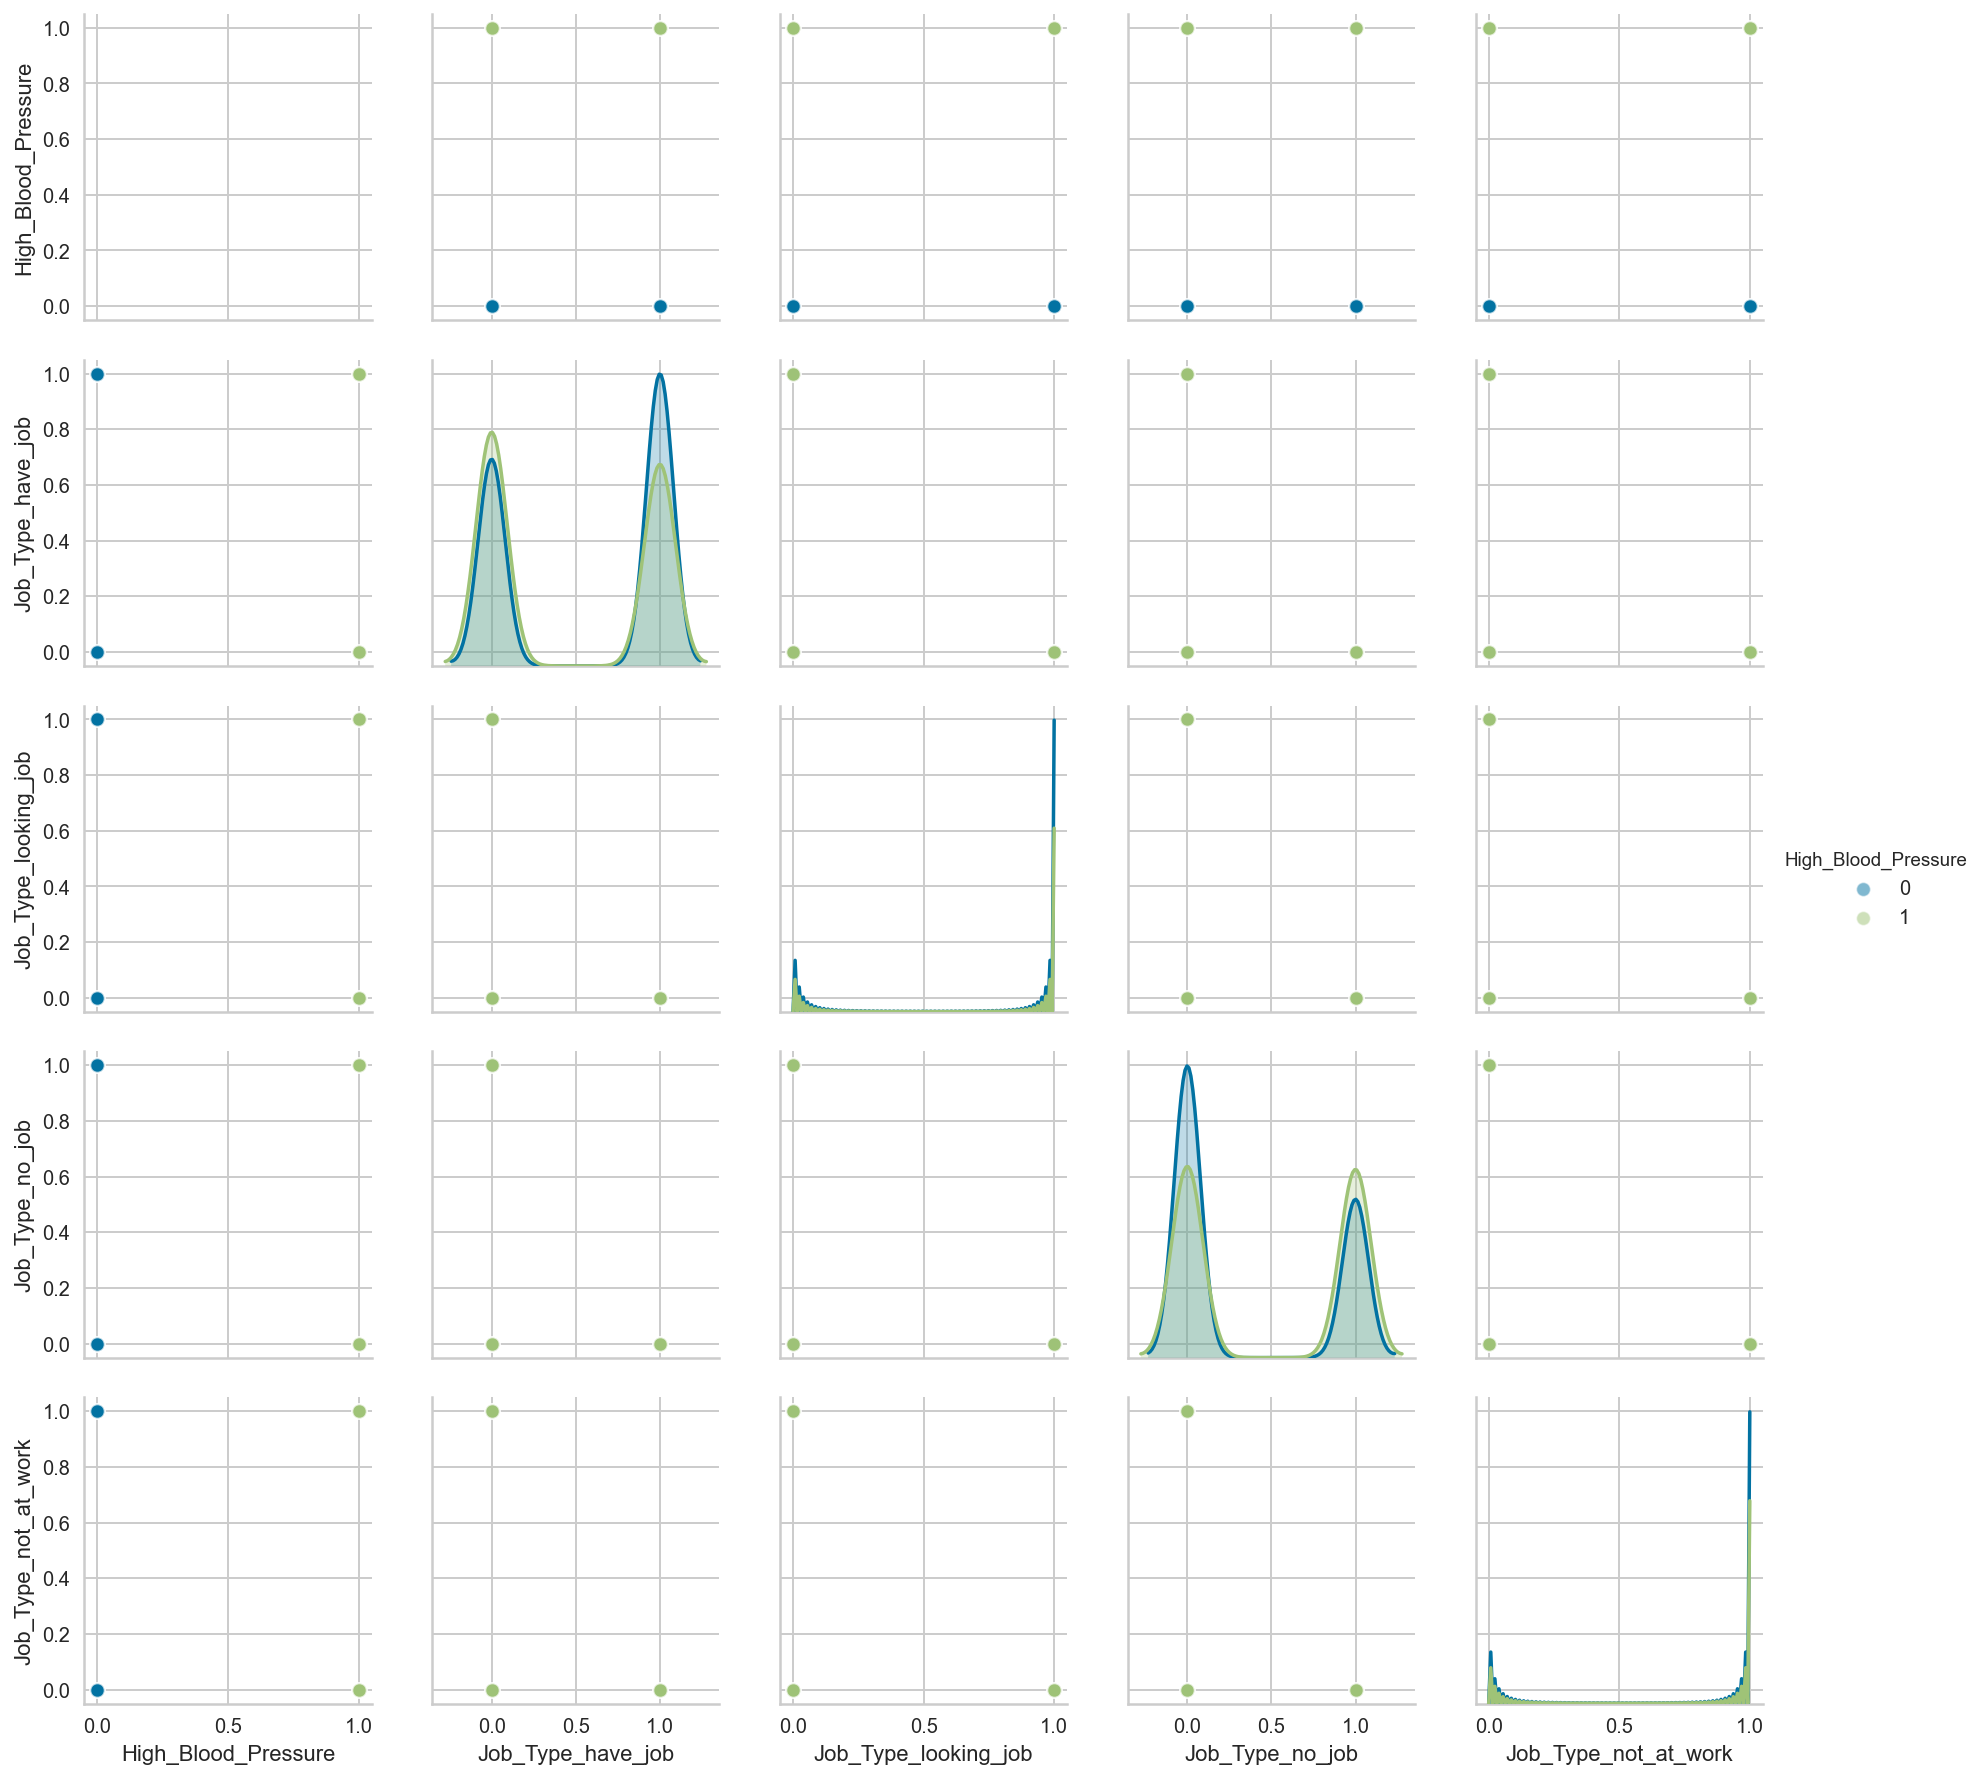

In [601]:
sns.pairplot(nhanes_train[['High_Blood_Pressure','Job_Type_have_job',
                           'Job_Type_looking_job',
                           'Job_Type_no_job','Job_Type_not_at_work'
                          ]],
             hue='High_Blood_Pressure', plot_kws=dict(alpha=.5));

#### Takeaways:
- No clear standouts of features here that will have a relationship with high blood pressure

-</br>
-</br>
## MODELING

-</br>
### Logistic Regression Model v1
Starting with model that has minimal features >

In [9]:
std_scale = StandardScaler()

#features we want to use in this model
v1_features = ['Age', 'Waist_Circum']

#create new X set of v1 features for training and test set
X_train_v1 = X_train[v1_features]
X_val_v1 = X_val[v1_features]
X_test_v1 = X_test[v1_features]

# scale all of the features for training and test set
X_train_scaled_v1 = std_scale.fit_transform(X_train_v1)
X_val_scaled_v1 = std_scale.fit_transform(X_val_v1)
X_test_scaled_v1 = std_scale.fit_transform(X_test_v1)

# create training model using scaled features
lm1 = LogisticRegression(solver='liblinear').fit(X_train_scaled_v1, y_train)

In [10]:
# create predicted values of lm1 model

pred_train_lm1 = lm1.predict(X_train_scaled_v1)
pred_val_lm1 = lm1.predict(X_val_scaled_v1)
pred_test_lm1 = lm1.predict(X_test_scaled_v1)

# create list of predicted probabilities for lm1 model

predict_prob_lm1 = lm1.predict_proba(X_test_scaled_v1)

-
#### F1 Score for lm1

In [11]:
print(f'Training F1 Score for lm1: {f1_score(pred_train_lm1, y_train)}')
print(f'Validation F1 Score for lm1: {f1_score(pred_val_lm1, y_val)}')
print(f'Test F1 Score for lm1: {f1_score(pred_test_lm1, y_test)}')

Training F1 Score for lm1: 0.4415748828965692
Validation F1 Score for lm1: 0.45348399246704335
Test F1 Score for lm1: 0.4403041825095057


-
#### Accuracy Score for lm1

In [12]:
# validate score/accuracy for the lm1 model

print(f'Training Accuracy Score for lm1: {lm1.score(X_train_scaled_v1, y_train)}')
print(f'Validation Accuracy Score for lm1: {lm1.score(X_val_scaled_v1, y_val)}')
print(f'Test Accuracy Score for lm1: {lm1.score(X_test_scaled_v1, y_test)}')


Training Accuracy Score for lm1: 0.6728958101594364
Validation Accuracy Score for lm1: 0.6772686832740213
Test Accuracy Score for lm1: 0.6725978647686833


#### Takeaways of Validation and Testing:
- Scores coming out relatively similiar, so feel good about model balance.  Hope to find ways to improve the scores though

-
#### Confusion Matrix for lm1

In [13]:
# create simple confusion matrix

confusion_matrix(y_test, pred_test_lm1)

array([[2445,  476],
       [ 996,  579]])

-
#### ROC AUC for lm1

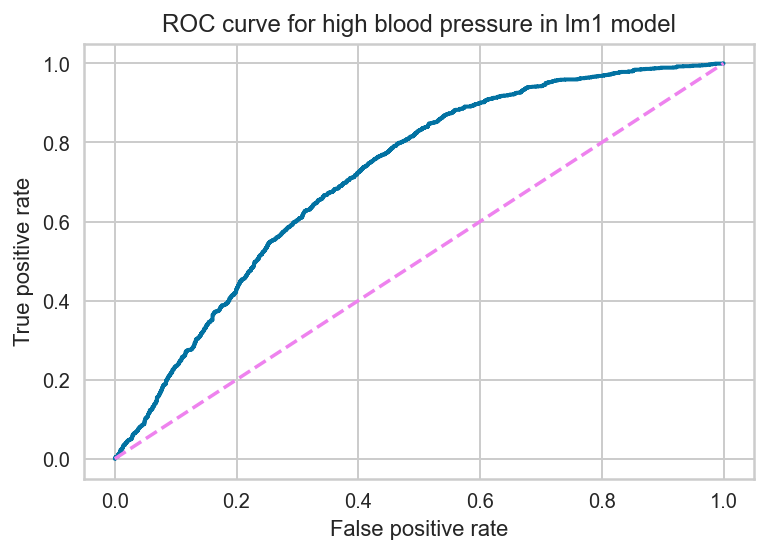

In [14]:
# plot ROC AUC curve

# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

# create metrics for ROC curve = false positive rate, true positive rate, thresholds

fpr_lm1, tpr_lm1, thresholds_lm1 = roc_curve(y_test, predict_prob_lm1[:,1])

plt.plot(fpr_lm1, tpr_lm1,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for high blood pressure in lm1 model');

In [15]:
# using the default threshold of 0.5

print("For lm1 model with threshold of 0.5 (default):")
print(f'''    Precision: {precision_score(y_test, pred_test_lm1)}, 
    Recall: {recall_score(y_test, pred_test_lm1)}''')

For lm1 model with threshold of 0.5 (default):
    Precision: 0.5488151658767773, 
    Recall: 0.3676190476190476


-</br>
Would like model to be more focused on recall performance, so am going to test lowering threshold >

In [16]:
# using the new threshold of 0.3
y_pred_lm1_thres3 = (lm1.predict_proba(X_test_scaled_v1)[:,1] > 0.3)

print("For lm1 model with threshold of 0.3:")
print(f'''    Precision: {precision_score(y_test, y_pred_lm1_thres3)}, 
    Recall: {recall_score(y_test, y_pred_lm1_thres3)}''')

For lm1 model with threshold of 0.3:
    Precision: 0.4846061575369852, 
    Recall: 0.7695238095238095


Recall is much better, but of course at sacrifice of precision with 0.3 threshold.</br>
-</br>
Now will take a look at weight/importance of the features >

In [17]:
# find coefficients

print('Coefficients for lm1 model:')
cofficients_lm1 = dict(zip(X_test_v1.columns, [x for nest in lm1.coef_ for x in nest]))
cofficients_lm1

Coefficients for lm1 model:


{'Age': 0.737839979537066, 'Waist_Circum': 0.30135218208025066}

In [18]:
# find intercept

print('Intercept for lm1 Model:')
print(lm1.intercept_)

Intercept for lm1 Model:
[-0.72278041]


-</br>
Let's get a full report for the model at 0.3 threshold >

In [19]:
print('Classification Report for lm1 model with 0.3 threshold:')
print(classification_report(y_test, y_pred_lm1_thres3))

Classification Report for lm1 model with 0.3 threshold:
              precision    recall  f1-score   support

           0       0.82      0.56      0.66      2921
           1       0.48      0.77      0.59      1575

    accuracy                           0.63      4496
   macro avg       0.65      0.66      0.63      4496
weighted avg       0.70      0.63      0.64      4496



-</br>
### Logistic Regression Model v2

Adding additional features to the Logistic Regression model.  Multiple combinations of features were tested for this model before landing on Age, Weight, Alcohol Amount, Race: Black, and Being Employed -- they performed the best >

In [20]:
std_scale = StandardScaler()

#features we want to use in this model (lm2)
v2_features = ['Age','Weight','Alcohol_Amt',
               'Race_Non_Hispanic_Black', 'Curr_Smoke'
              ]

#create new X set of v2 features for training and test set
X_train_v2 = X_train[v2_features]
X_val_v2 = X_val[v2_features]
X_test_v2 = X_test[v2_features]

# scale all of the features for training and test set
X_train_scaled_v2 = std_scale.fit_transform(X_train_v2)
X_val_scaled_v2 = std_scale.fit_transform(X_val_v2)
X_test_scaled_v2 = std_scale.fit_transform(X_test_v2)

# create training model using scaled features
lm2 = LogisticRegression(solver='liblinear').fit(X_train_scaled_v2, y_train)


In [21]:
# create predicted values of lm2 model

pred_train_lm2 = lm2.predict(X_train_scaled_v2)
pred_val_lm2 = lm2.predict(X_val_scaled_v2)
pred_test_lm2 = lm2.predict(X_test_scaled_v2)

# create list of predicted probabilities for lm2 model

predict_prob_lm2 = lm2.predict_proba(X_test_scaled_v2)

-
#### F1 Score for lm2

In [22]:
print(f'Training F1 Score for lm2: {f1_score(pred_train_lm2, y_train)}')
print(f'Validation F1 Score for lm2: {f1_score(pred_val_lm2, y_val)}')
print(f'Test F1 Score for lm2: {f1_score(pred_test_lm2, y_test)}')

Training F1 Score for lm2: 0.4749568221070812
Validation F1 Score for lm2: 0.4705020153902529
Test F1 Score for lm2: 0.4500934579439252


-
#### Accuracy Score for lm2

In [23]:
# validate score/accuracy for the lm2 model

print(f'Training Accuracy Score for lm2: {lm2.score(X_train_scaled_v2, y_train)}')
print(f'Validation Accuracy Score for lm2: {lm2.score(X_val_scaled_v2, y_val)}')
print(f'Test Accuracy Score for lm2: {lm2.score(X_test_scaled_v2, y_test)}')

Training Accuracy Score for lm2: 0.6843900630329997
Validation Accuracy Score for lm2: 0.6786032028469751
Test Accuracy Score for lm2: 0.6728202846975089


#### Takeaways of Test:
- Again all validation and tests are relatively the same, so model not over or under fitting. Scores are up slightly from lm1 model.  Age & Weight are going to be strong predictors, and other features will only improve it slightly, but will try playing with more parameters to improve.

-</br>

Will look at other metrics to see how good this model really is compared to others >

In [24]:
# create simple confusion matrix

confusion_matrix(y_test, pred_test_lm2)

array([[2423,  498],
       [ 973,  602]])

In [25]:
# plot the confusion matrix

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test_scaled_v2)[:, 1] >= threshold)
    bp_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(bp_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Safe BP', 'High BP'],
           yticklabels=['Safe BP', 'High BP']);
    plt.title('Confusion Matrix for High Blood Pressure Logistic Reg Model')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

For lm2 model, 0.5 threshold:


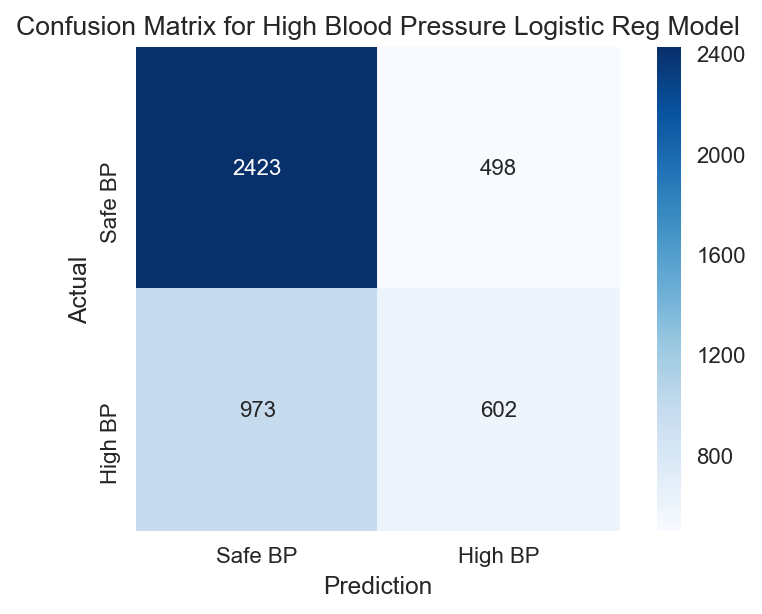

In [26]:
# version with default threshold of 0.5
print('For lm2 model, 0.5 threshold:')
make_confusion_matrix(lm2)

#### Takeaways of Confusion Matrix:
- Higher precision than recall with default threshold, but again will want higher recall, as it will be more important to catch those that do have high blood pressure vs. asking others who actually don't have high blood pressure to come back in for testing (i.e. the False Positives)

FOR lm2 model, 0.31 threshold:


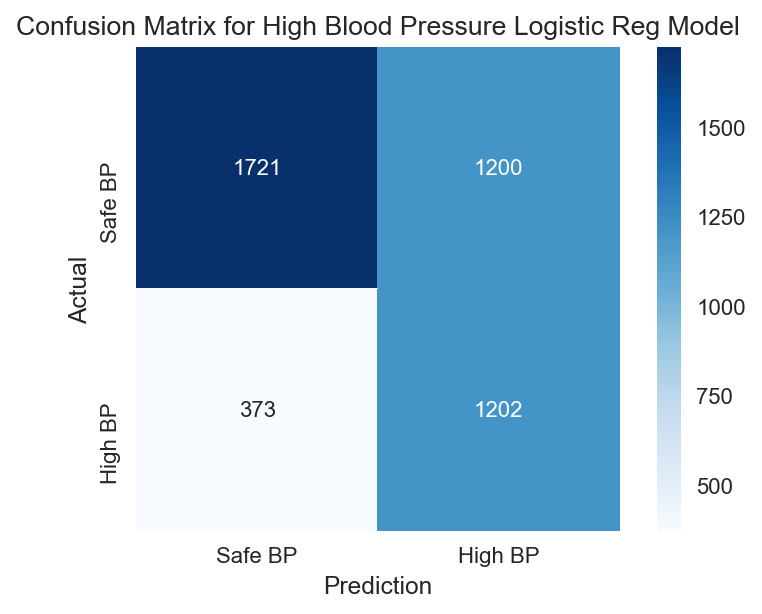

In [27]:
# version of confusion matrix with .31 threshold

print('FOR lm2 model, 0.31 threshold:')
make_confusion_matrix(lm2, threshold=0.31)

#### Takeaways of Confusion Matrix - Threshold tests:
- Tried playing with various thresholds and 0.31 is likely the direction we want to take for a threshold.  This means there are a very high number of people with False Positives, but lowers the False Negatives to a point where will capture many who do have high blood pressure

-</br>
Now let's look at the betas for the model to understand importance of features >

In [28]:
# find coefficients for this lm2 model

print('COEFFICIENTS for lm2 model:')
cofficients_lm2 = dict(zip(X_test_v2.columns, [x for nest in lm2.coef_ for x in nest]))
pd.DataFrame.from_dict(cofficients_lm2, orient='index', columns=['lm2_coefs'])

COEFFICIENTS for lm2 model:


lm2_coefs
Age                       0.867535
Weight                    0.303634
Alcohol_Amt               0.148658
Race_Non_Hispanic_Black   0.166254
Curr_Smoke                0.008461

In [29]:
print('INTERCEPT for lm2 Model:')
print(lm2.intercept_)

INTERCEPT for lm2 Model:
[-0.73701979]


-
#### ROC AUC Score
Now let's examine the ROC AUC score >

ROC AUC score for lm2 model =  0.7203629981034979


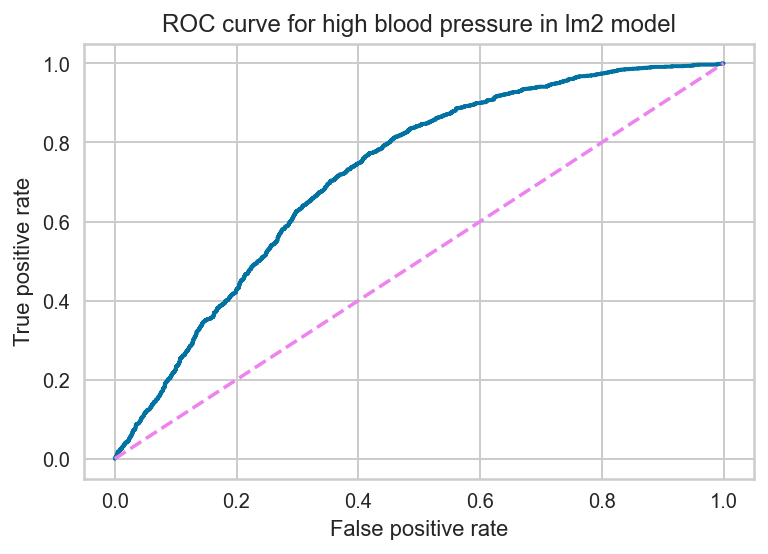

In [30]:
# create metrics for ROC curve = false positive rate, true positive rate, thresholds

fpr_lm2, tpr_lm2, thresholds_lm2 = roc_curve(y_test, predict_prob_lm2[:,1])

# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

plt.plot(fpr_lm2, tpr_lm2,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for high blood pressure in lm2 model');
print("ROC AUC score for lm2 model = ", roc_auc_score(y_test, predict_prob_lm2[:,1]))

-
#### Precision & Recall Scores
Looking at difference between default and .31 threshold identified above

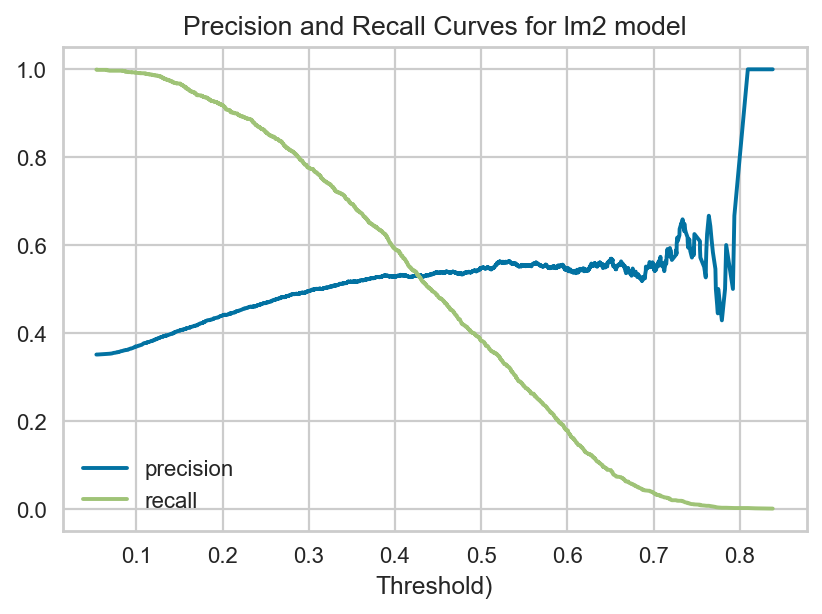

In [31]:
# Build graph of precision & recall curves along threshold to understand their relationship
#    and examine threshold options

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, predict_prob_lm2[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold)');
plt.title('Precision and Recall Curves for lm2 model');

In [32]:
# using the default threshold of 0.5

print("For lm2 model with threshold of 0.5 (default):")
print(f'''    Precision: {precision_score(y_test, pred_test_lm2)}, 
    Recall: {recall_score(y_test, pred_test_lm2)}''')

For lm2 model with threshold of 0.5 (default):
    Precision: 0.5472727272727272, 
    Recall: 0.38222222222222224


In [33]:
# using the new threshold of 0.31

y_pred_lm2_thres23 = (lm2.predict_proba(X_test_scaled_v2)[:,1] > 0.23)
print("For lm2 model with threshold of 0.23:")
print(f'''    Precision: {precision_score(y_test, y_pred_lm2_thres23)}, 
    Recall: {recall_score(y_test, y_pred_lm2_thres23)}''')

For lm2 model with threshold of 0.23:
    Precision: 0.4580327868852459, 
    Recall: 0.886984126984127


#### Takeaways of Precision & Recall scores:
- To get recall to a really strong place, needed to drop threshold down to 0.23 for model.

-
#### Full Classification Report
At .23 threshold

In [34]:
print('Classification Report for lm2 model with 0.23 threshold:')
print(classification_report(y_test, y_pred_lm2_thres23))

Classification Report for lm2 model with 0.23 threshold:
              precision    recall  f1-score   support

           0       0.88      0.43      0.58      2921
           1       0.46      0.89      0.60      1575

    accuracy                           0.59      4496
   macro avg       0.67      0.66      0.59      4496
weighted avg       0.73      0.59      0.59      4496



-</br>
### Logistic Regression With Oversampling Model
Because we have an imbalanced split of our target (approx 35% positive and 65% negative) will try to see if correcting for imbalance will improve model.  Will try oversampling for the 'minority class' (those with high blood pressure) >

In [35]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_train_over, y_train_over = ros.fit_sample(X_train_scaled_v2,y_train)
X_val_over, y_val_over = ros.fit_sample(X_val_scaled_v2,y_val)

In [36]:
# build clf1 model

lm3 = LogisticRegression(solver='liblinear')
lm3.fit(X_train_over, y_train_over)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
# create predicted values of lm3 model

pred_train_lm3 = lm3.predict(X_train_scaled_v2)
pred_val_lm3 = lm3.predict(X_val_scaled_v2)
pred_test_lm3 = lm3.predict(X_test_scaled_v2)

# create list of predicted probabilities for lm2 model

predict_prob_lm3 = lm3.predict_proba(X_test_scaled_v2)

-
#### F1 Score for clf1

In [38]:
print(f'Training F1 Score for lm3: {f1_score(pred_train_lm3, y_train)}')
print(f'Validation F1 Score for lm3: {f1_score(pred_val_lm3, y_val)}')
print(f'Test F1 Score for lm3: {f1_score(pred_test_lm3, y_test)}')

Training F1 Score for lm3: 0.5901994404837109
Validation F1 Score for lm3: 0.5992974871656309
Test F1 Score for lm3: 0.5920519059205189


-
#### Accuracy Score for clf1

In [39]:
# validate score/accuracy for the lm2 model

print(f'Training Accuracy Score for lm3: {lm3.score(X_train_scaled_v2, y_train)}')
print(f'Validation Accuracy Score for lm3: {lm3.score(X_val_scaled_v2, y_val)}')
print(f'Test Accuracy Score for lm3: {lm3.score(X_test_scaled_v2, y_test)}')

Training Accuracy Score for lm3: 0.6632554690396737
Validation Accuracy Score for lm3: 0.6701512455516014
Test Accuracy Score for lm3: 0.6643683274021353


#### Takeaways of Test:
- Again all validation and tests are relatively the same, so model not over or under fitting. 
- F1 score has improved compared to lm1 & lm2 models.  Accuracy score hasn't changed much though (down slightly)</br>

-</br>

Will look at other metrics to see how good this model really is compared to others >

#### Confusion Matrix for clf1

FOR lm3 model, default 0.5 threshold:


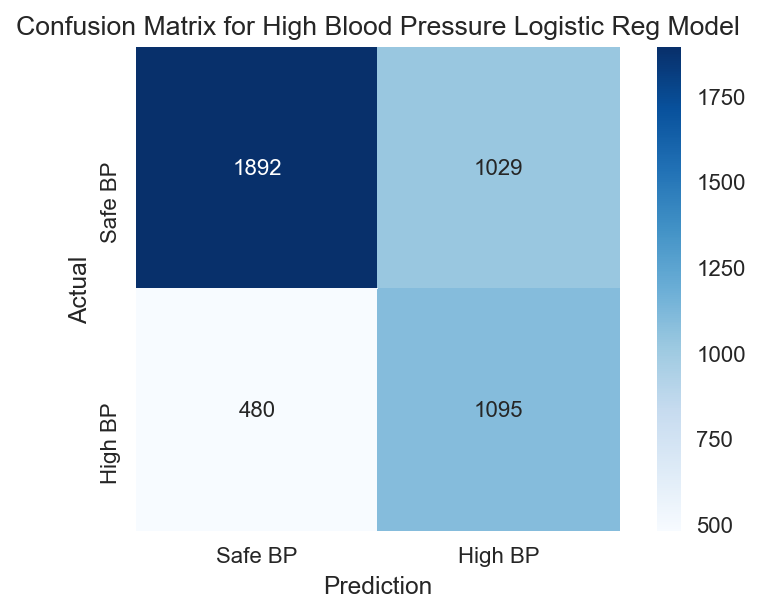

In [40]:
print('FOR lm3 model, default 0.5 threshold:')
make_confusion_matrix(lm3)

FOR lm3 model, 0.4 threshold:


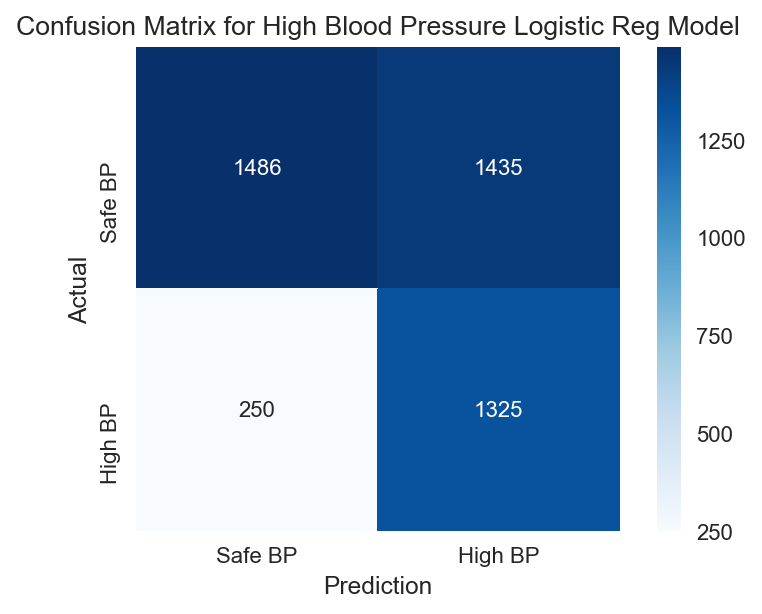

In [41]:
print('FOR lm3 model, 0.4 threshold:')
make_confusion_matrix(lm3, threshold=0.4)

#### TAKEAWAYS
- Can set a higher threshold now and have less false negatives without false positives getting too far out of control.  Let's look more closely at other metrics to compare to lm2 >

-
#### ROC AUC for clf1

In [42]:
print("ROC AUC score for lm3 model = ", roc_auc_score(y_test, pred_test_lm3))

ROC AUC score for lm3 model =  0.6714807388206908


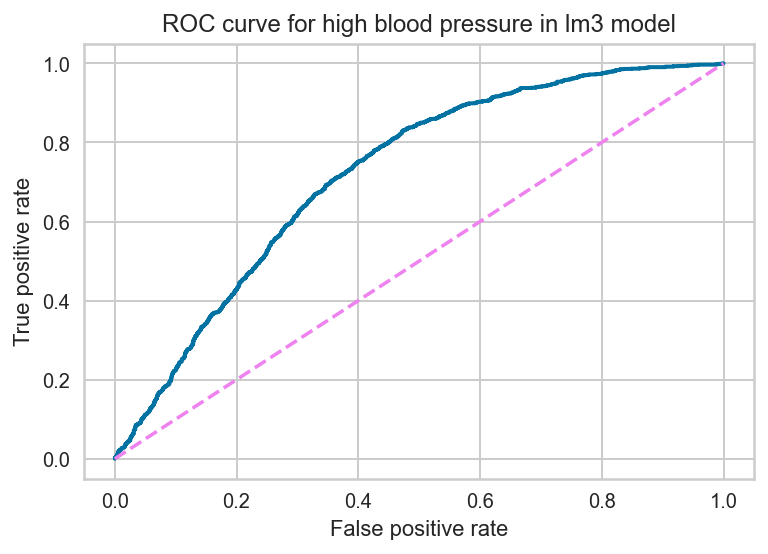

In [43]:
# plot ROC curve

# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

# create metrics for ROC curve = false positive rate, true positive rate, thresholds

fpr_lm3, tpr_lm3, thresholds_lm3 = roc_curve(y_test, predict_prob_lm3[:,1])

plt.plot(fpr_lm3, tpr_lm3,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for high blood pressure in lm3 model');

-
#### Precision & Recall for clf1

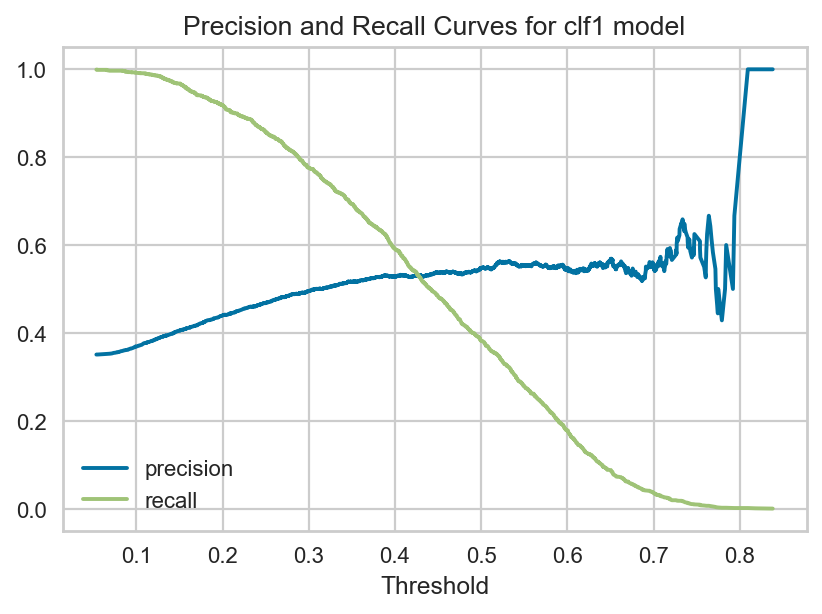

In [44]:
# Build graph of precision & recall curves along threshold to understand their relationship
#    and examine threshold options

precision_curve_clf1, recall_curve_lm3, threshold_curve_lm3 = precision_recall_curve(
    y_test, predict_prob_lm3[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves for clf1 model');


In [45]:
# Test - Recall & Precision for default 0.5 threshold
print("For lm3 model at default threshold (0.5):")
print(f'''    Precision: {precision_score(y_test, pred_test_lm3)}, 
    Recall: {recall_score(y_test, pred_test_lm3)}''')

For lm3 model at default threshold (0.5):
    Precision: 0.5155367231638418, 
    Recall: 0.6952380952380952


In [46]:
# create predicted probabilities of clf1 model at 0.34 thresholds

y_pred_lm3_thres34 = (lm3.predict_proba(X_test_scaled_v2)[:,1] > 0.34)

In [47]:
# Recall & Precision for threshold of 0.34
print("lm3 model at threshold of 0.34:")
print(f'''    Precision: {precision_score(y_test, y_pred_lm3_thres34)}, 
    Recall: {recall_score(y_test, y_pred_lm3_thres34)}''')

lm3 model at threshold of 0.34:
    Precision: 0.4535554131966688, 
    Recall: 0.8990476190476191


In [48]:
# F1 score

print(f'F1 SCORE for lm3 model with 0.34 threshold: {f1_score(y_test, y_pred_lm3_thres34)}')

F1 SCORE for lm3 model with 0.34 threshold: 0.6029380455609964


#### TAKEAWAYS
- Can put a higher threshold to still get a higher recall than lm1 and lm2 models, but precision is dipping.  Very similiar scores, but since recall is of more importance and like to avoid having to put threshold too low for simplicity of modeling, currently leaning towards using clf1 model

Let's now get the betas for this model >

In [51]:
# find coefficients for this lm3 model

print('SCALED COEFFICIENTS for lm3 Model:')
cofficients_lm3 = dict(zip(X_test_v2.columns, [x for nest in lm3.coef_ for x in nest]))
cofficients_lm3_df = pd.DataFrame.from_dict(cofficients_lm3, orient='index', columns=['clf1_coefs'])
cofficients_lm3_df

SCALED COEFFICIENTS for lm3 Model:


clf1_coefs
Age                        0.887286
Weight                     0.340309
Alcohol_Amt                0.139165
Race_Non_Hispanic_Black    0.152445
Curr_Smoke                 0.005032

In [52]:
print('INTERCEPT for lm3 Model:')
print(lm3.intercept_)

INTERCEPT for lm3 Model:
[-0.12078719]


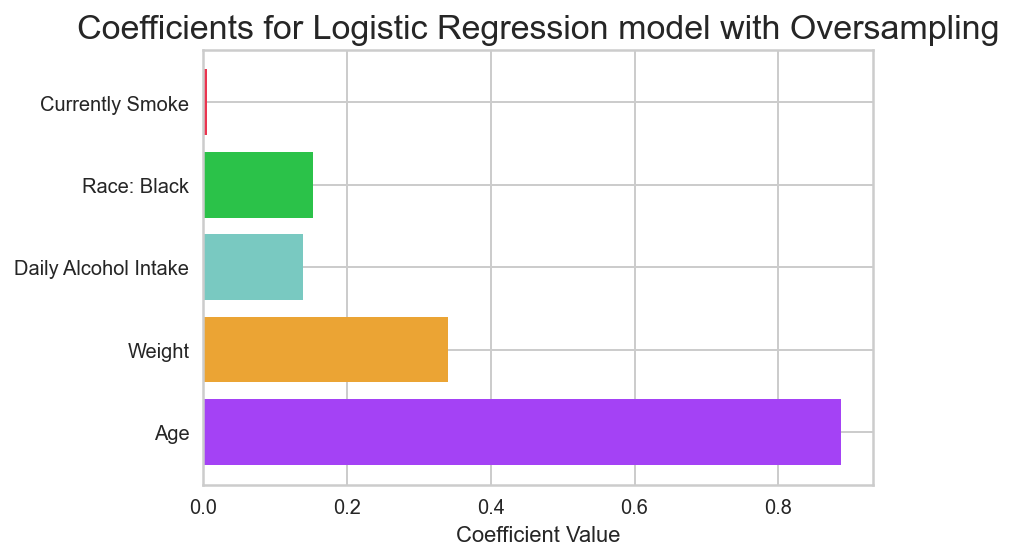

In [53]:
# plot coefficients for clf1 model

x = ['Age','Weight','Daily Alcohol Intake','Race: Black', 'Currently Smoke']
coefs = list(cofficients_lm3_df.clf1_coefs)

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, coefs, color=['#a442f5','#eba434','#79c9c1','#2bc249', '#eb344f'])
#plt.ylabel("", size=13)
plt.xlabel("Coefficient Value", size=11)
plt.title("Coefficients for Logistic Regression model with Oversampling", size = 17)

plt.yticks(x_pos, x)

plt.show()

-
### Decision Tree Model
For sake of always trying options to find optimal performance of models, will now try decision tree models to predict high blood pressure


First, using v2 of narrowed features (5 total) used in lm2 and clf1 above >

In [54]:
dt1 = DecisionTreeClassifier(max_depth=6)

dt1.fit(X_train_v2, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [55]:
# create predicted values of dt1 model

pred_train_dt1 = dt1.predict(X_train_v2)
pred_test_dt1 = dt1.predict(X_test_v2)

# create list of predicted probabilities for dt1 model

predict_prob_dt1 = dt1.predict_proba(X_train_v2)

-
#### Validation Score

In [56]:
# K-Fold Class Validation Scores

scores_dt1 = cross_val_score(dt1, X_train, y_train, cv=5, scoring='f1')
scores_dt1.mean()

0.452737821843234

-
#### F1 Score

In [57]:
# find preditions for training and test sets

print(f'Training F1 Score: {f1_score(pred_train_dt1, y_train)}')
print(f'Testing F1 Score: {f1_score(pred_test_dt1, y_test)}')

Training F1 Score: 0.5055788842231554
Testing F1 Score: 0.4796511627906977


-
#### Confusion Matrix

In [58]:
# create simple confusion matrix

confusion_matrix(y_test, pred_test_dt1)

array([[2404,  517],
       [ 915,  660]])

-
#### Precision & Recall

In [59]:
# find precision & recall for dt1 model

print("For dt1 model:")
print(f'''    Precision: {precision_score(y_test, pred_test_dt1)}, 
    Recall: {recall_score(y_test, pred_test_dt1)}''')

For dt1 model:
    Precision: 0.5607476635514018, 
    Recall: 0.41904761904761906


In [60]:
# now using the new threshold of 0.23 for dt model

y_predict_dt1_thres23 = (dt1.predict_proba(X_test_v2)[:,1] > 0.23)
print("Model dt1 with 0.23 threshold:")
print(f'''   Precision: {precision_score(y_test, y_predict_dt1_thres23)}, 
   Recall: {recall_score(y_test, y_predict_dt1_thres23)}''')

Model dt1 with 0.23 threshold:
   Precision: 0.4524727039177906, 
   Recall: 0.8946031746031746


#### Takeaways of dt1 model:
- Not performing better than lm3 model and at lower threshold than lm3 so likely not going to be selection.  Let's try going broader with the all the features in teh decision tree >

-
### Decision Tree Model w/All Features
Opening model to try to work with all original features

In [61]:
dt2 = DecisionTreeClassifier()

dt2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [62]:
# create predicted values of dt2 model

pred_train_dt2 = dt2.predict(X_train)
pred_test_dt2 = dt2.predict(X_test)

# create list of predicted probabilities for dt2 model

predict_prob_dt2 = dt2.predict_proba(X_train)

-
#### Validation Score

In [63]:
# K-Fold Class Validation Scores

scores_dt2 = cross_val_score(dt2, X_train, y_train, cv=5, scoring='f1')
scores_dt2.mean()

0.4554976253647614

-
#### F1 Score - Comparing Train & Test Data

In [64]:
# find preditions for training and test sets

print(f'Training F1 Score: {f1_score(pred_train_dt2, y_train)}')
print(f'Testing F1 Score: {f1_score(pred_test_dt2, y_test)}')

Training F1 Score: 1.0
Testing F1 Score: 0.45397620538509703


#### Takeaways of dt2 model's test:
- Not surprisingly, overfitting.  We'll revist this model to correct this with GridSearchCV if feel like valuable after exploring other models.

-
#### Confusion Matrix

In [65]:
# create simple confusion matrix

confusion_matrix(y_test, pred_test_dt2)

array([[2027,  894],
       [ 850,  725]])

-
#### Accuracy Score

In [66]:
print(f'ACCURACY SCORE for dt2 model:{dt2.score(X_test, y_test)}')

ACCURACY SCORE for dt2 model:0.6120996441281139


-
#### Precision & Recall

In [67]:
# using default threshold
print("For dt2 model with default threshold:")
print(f'''Precision: {precision_score(y_test, pred_test_dt2)}, 
Recall: {recall_score(y_test, pred_test_dt2)}''')

For dt2 model with default threshold:
Precision: 0.4478072884496603, 
Recall: 0.4603174603174603


In [68]:
# using the new threshold of 0.23
y_predict_dt2_thres23 = (dt2.predict_proba(X_test)[:,1] > 0.23)

print("Model dt2 with 0.23 threshold:")
print(f'''   Precision: {precision_score(y_test, y_predict_dt2_thres23)}, 
   Recall: {recall_score(y_test, y_predict_dt2_thres23)}''')

Model dt2 with 0.23 threshold:
   Precision: 0.4478072884496603, 
   Recall: 0.4603174603174603


The 0.23 threshold was still the best that could be done to get recall up near where our lm3 model was performing without extreme sacrifice to precision -- but both still less than lm3 model, so isn't standing out as better option

In [69]:

print(f'F1 SCORE for dt2 model with 0.23 threshold: {f1_score(y_test, y_predict_dt2_thres23)}')

F1 SCORE for dt2 model with 0.23 threshold: 0.45397620538509703


#### TAKEAWAYS FOR 'ALL FEATURE' DECISION TREE
- Can get slightly better scores if using all features, but had to set max_depth to 54 to get recall higher than precision -- and still both numbers are less than logistic regression balanced model (lm3), so doesn't seem like good approach

*Now to look at the Random Forest model to see if can improve model >*

-
### Random Forest Model


First, again using v2 of narrowed features (5 total) used in lm2 and lm3 above

In [70]:
rf1 = RandomForestClassifier(n_estimators=100)

rf1.fit(X_train_v2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [71]:
# create predicted values of rf1 model

pred_train_rf1 = rf1.predict(X_train_v2)
pred_test_rf1 = rf1.predict(X_test_v2)

# create list of predicted probabilities for rf1 model

predict_prob_rf1 = rf1.predict_proba(X_test_v2)

-
#### Validation Score

In [72]:
# K-Fold Class Validation Scores

scores_rf1 = cross_val_score(rf1, X_train_v2, y_train, cv=5, scoring='f1')
scores_rf1.mean()

0.4553500451191792

-
#### F1 Score - Comparing Train & Test Data

In [73]:
# find preditions for training and test sets

print(f'Training F1 Score: {f1_score(pred_train_rf1, y_train)}')
print(f'Testing F1 Score: {f1_score(pred_test_rf1, y_test)}')

Training F1 Score: 0.9841909814323607
Testing F1 Score: 0.4465885596140593


#### Takeaways of rf1 model's test:
- Not good!  Looks like overfitting.  Need to correct for this.  Let's now do GridSearchCV to find best model >

In [90]:
# create the parameters we want to work within

parameters = {'n_estimators': (10,30,50,70,90,100),
              'criterion': ('gini','entropy'),
              'max_depth': (3,5,7,9,10),
              'max_features': ('auto','sqrt'),
              'min_samples_split': (2,3,5),
             }

In [103]:
# create GridSearchCV'd Random Forest model

rf1_grid = GridSearchCV(RandomForestClassifier(),
                        param_grid = parameters, cv=5,
                        verbose = True)

In [92]:
# train new GridSearchCV'd Random Forest model
rf1_grid = rf1_grid.fit(X_train_v2, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 11.7min finished


In [93]:
# find what the best estimator is

rf1_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [99]:
rf1_grid.best_score_

0.6881720430107527

In [94]:
# create new Random Forest model based on 'best' results from the Grid Search

rf1_best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [95]:
# fit new 'best' Random Forest model

rf1_best.fit(X_train_v2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [104]:
# create predicted values of rf1_best model

pred_train_rf1_best = rf1_best.predict(X_train_v2)
pred_test_rf1_best = rf1_best.predict(X_test_v2)

# create list of predicted probabilities for rf1_best model

predict_prob_rf1_best = rf1_best.predict_proba(X_test_v2)

In [101]:
# find preditions for training and test sets

print(f'Training F1 Score: {f1_score(pred_train_rf1_best, y_train)}')
print(f'Testing F1 Score: {f1_score(pred_test_rf1_best, y_test)}')

Training F1 Score: 0.5018291913712628
Testing F1 Score: 0.44067796610169485


-
#### Confusion Matrix

In [102]:
# create simple confusion matrix

confusion_matrix(y_test, pred_test_rf1_best)

array([[2472,  449],
       [1003,  572]])

-
#### ROC AUC curve

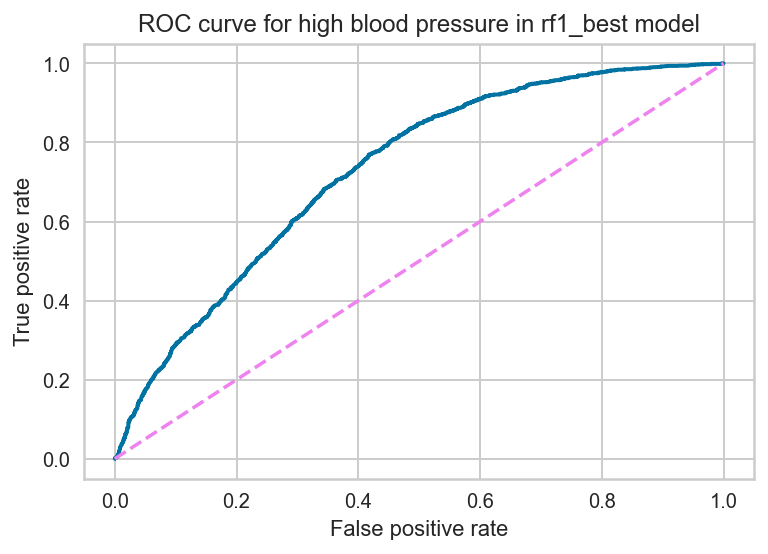

In [139]:
# plot ROC curve

# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

# create metrics for ROC curve = false positive rate, true positive rate, thresholds

fpr_rf1_best, tpr_rf1_best, thresholds_rf1_best = roc_curve(y_test, predict_prob_rf1_best[:,1])

plt.plot(fpr_rf1_best, tpr_rf1_best,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for high blood pressure in rf1_best model');

-
#### Feature Importance

In [105]:
feat_importance_rf1_best = dict(zip(X_test_v2.columns, rf1_best.feature_importances_))
feat_importance_rf1_best

{'Age': 0.6825511476167349,
 'Weight': 0.22252421653859164,
 'Alcohol_Amt': 0.05608449334178214,
 'Race_Non_Hispanic_Black': 0.027523482208273952,
 'Curr_Smoke': 0.011316660294617467}

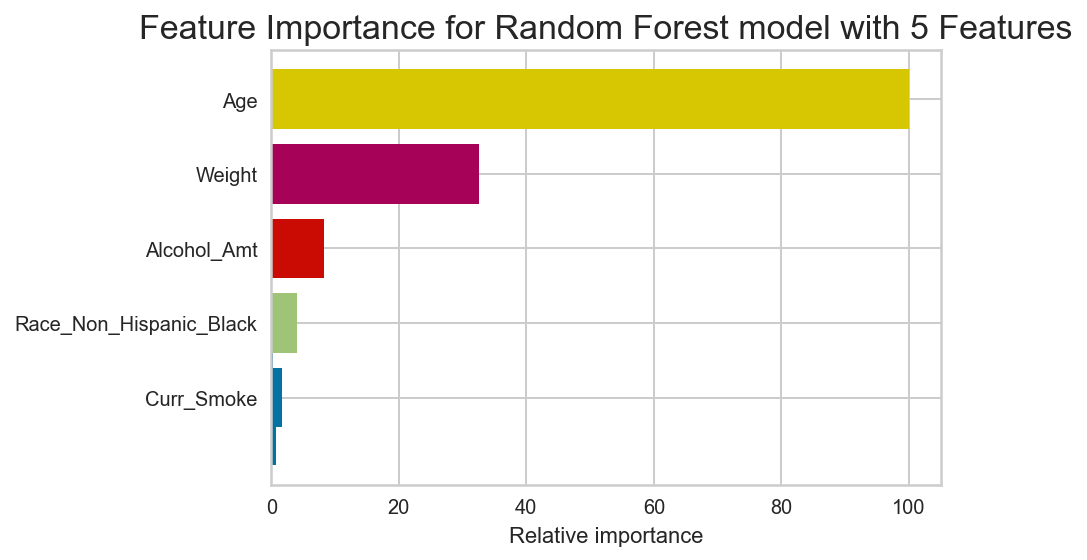

In [113]:
# plot coefficients for model

x = ['Age','Weight','Daily Alcohol Intake','Race: Black', 'Currently Smoke']

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, rf1_best.feature_importances_)

viz = FeatureImportances(rf1_best)
viz.fit(X_train_v2, y_train)

plt.xlabel("Relative importance", size=11)
plt.title("Feature Importance for Random Forest model with 5 Features", size = 17)


plt.show()

Odd line appearing under curr_smoke.  Troubleshooted without success in getting rid of it.  If this ends up being model used, will need to correct before showing as final!

-
#### Precision & Recall

In [114]:

print("For rf1 model:")
print(f'''   Precision: {precision_score(y_test, pred_test_rf1)}, 
   Recall: {recall_score(y_test, pred_test_rf1)}''')

For rf1 model:
   Precision: 0.4883195177091183, 
   Recall: 0.4114285714285714


In [124]:

# get predicted probabilities for rf1 model at new threshold of 0.24
y_pred_rf1_best_thres24 = (rf1_best.predict_proba(X_test_v2)[:,1] > 0.24)

In [125]:
# using the new threshold of 0.24
print("Model rf1 with 0.24 threshold:")
print(f'''   Precision: {precision_score(y_test, y_pred_rf1_best_thres24)}, 
   Recall: {recall_score(y_test, y_pred_rf1_best_thres24)}''')

Model rf1 with 0.24 threshold:
   Precision: 0.45472061657032753, 
   Recall: 0.8990476190476191


#### TAKEAWAYS for rf1 model
- Precision and Recall are both very similiar to lm3 model when lowering threshold to .24.  This threshold is lower than the lm3 model though.  Not a strong 'clear winner' as of yet.

Will again try opening all features up to see if that makes any difference in performance >

-
### Random Forest Model w/All Features
Opening model to try to work with all original features

In [99]:
rf2 = RandomForestClassifier(n_estimators=100)

rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [102]:
# create predicted values of rf2 model

pred_train_rf2 = rf2.predict(X_train)
pred_test_rf2 = rf2.predict(X_test)

# create list of predicted probabilities for rf2 model

predict_prob_rf2 = rf2.predict_proba(X_test)


In [101]:
# K-Fold Class Validation Scores

scores_rf2 = cross_val_score(rf2, X_train, y_train, cv=5, scoring='f1')
scores_rf2.mean()

0.4590812933975882

In [109]:
# find preditions for training and test sets

print(f'Training F1 Score: {f1_score(pred_train_rf2, y_train)}')
print(f'Testing F1 Score: {f1_score(pred_test_rf2, y_test)}')

Training F1 Score: 1.0
Testing F1 Score: 0.46239761727475803


#### Takeaways of rf2 model's test:
- Not good!  Looks like overfitting again.  Need to correct for this. >

In [146]:
# create the parameters we want to work within

parameters_rf2 = {'n_estimators': (50,70,90,100),
                  'criterion': ('gini','entropy'),
                  'max_depth': (7,9,10,12,14),
                  'max_features': ('auto','sqrt','log2'),
                  'min_samples_split': (2,3,5,7),
                 }

In [147]:
# create GridSearchCV'd Random Forest model

rf2_grid = GridSearchCV(RandomForestClassifier(),
                        param_grid = parameters_rf2, cv=5,
                        verbose = True)

In [151]:
# train new GridSearchCV'd Random Forest model

rf2_grid = rf2_grid.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [152]:
rf2_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [149]:
rf2_grid.best_score_

0.6876529477196885

In [153]:
# create new Random Forest model based on 'best' results from the Grid Search

rf2_best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [155]:
# fit new 'best' random forest model

rf2_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [156]:
# create predicted values of rf1_best model

pred_train_rf2_best = rf2_best.predict(X_train)
pred_test_rf2_best = rf2_best.predict(X_test)

# create list of predicted probabilities for rf1_best model

predict_prob_rf2_best = rf2_best.predict_proba(X_test)

In [157]:
# find new preditions for training and test sets

print(f'Training F1 Score: {f1_score(pred_train_rf2_best, y_train)}')
print(f'Testing F1 Score: {f1_score(pred_test_rf2_best, y_test)}')

Training F1 Score: 0.571876224050137
Testing F1 Score: 0.4171729445119482


-
#### ROC AUC

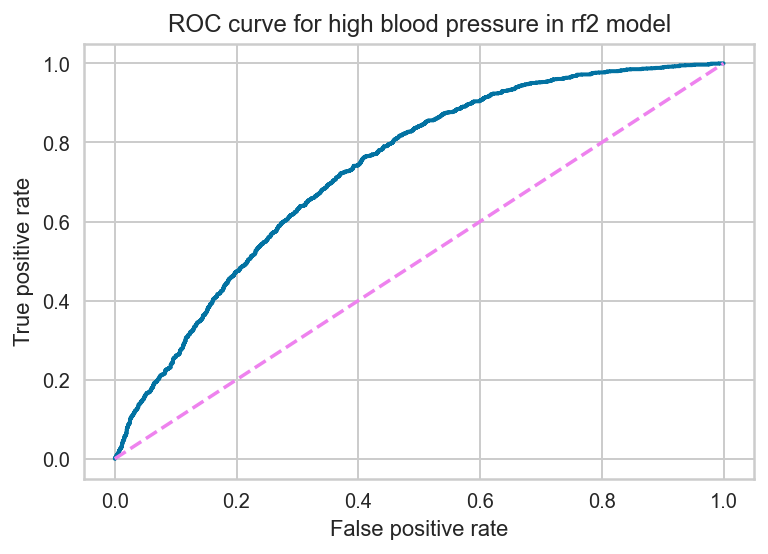

In [158]:
# plot ROC curve

# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

# create metrics for ROC curve = false positive rate, true positive rate, thresholds

fpr_rf2_best, tpr_rf2_best, thresholds_rf2_best = roc_curve(y_test, predict_prob_rf2_best[:,1])

plt.plot(fpr_rf2_best, tpr_rf2_best,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for high blood pressure in rf2 model');

-
#### Precision & Recall

In [159]:

print("For rf2_best model:")
print(f'''    Precision: {precision_score(y_test, pred_test_rf2_best)}, 
    Recall: {recall_score(y_test, pred_test_rf2_best)}''')

For rf2_best model:
    Precision: 0.5760626398210291, 
    Recall: 0.326984126984127


In [171]:

# get predicted probabilities for rf1 model at new threshold of 0.26
y_pred_rf2_best_thres26 = (rf2_best.predict_proba(X_test)[:,1] > 0.26)

In [172]:
# using the new threshold of 0.26

print("Model rf2_best with 0.26 threshold:")
print(f'''   Precision: {precision_score(y_test, y_pred_rf2_best_thres26)}, 
   Recall: {recall_score(y_test, y_pred_rf2_best_thres26)}''')

Model rf2_best with 0.26 threshold:
   Precision: 0.45457474226804123, 
   Recall: 0.8958730158730158


-
#### Feature Importance

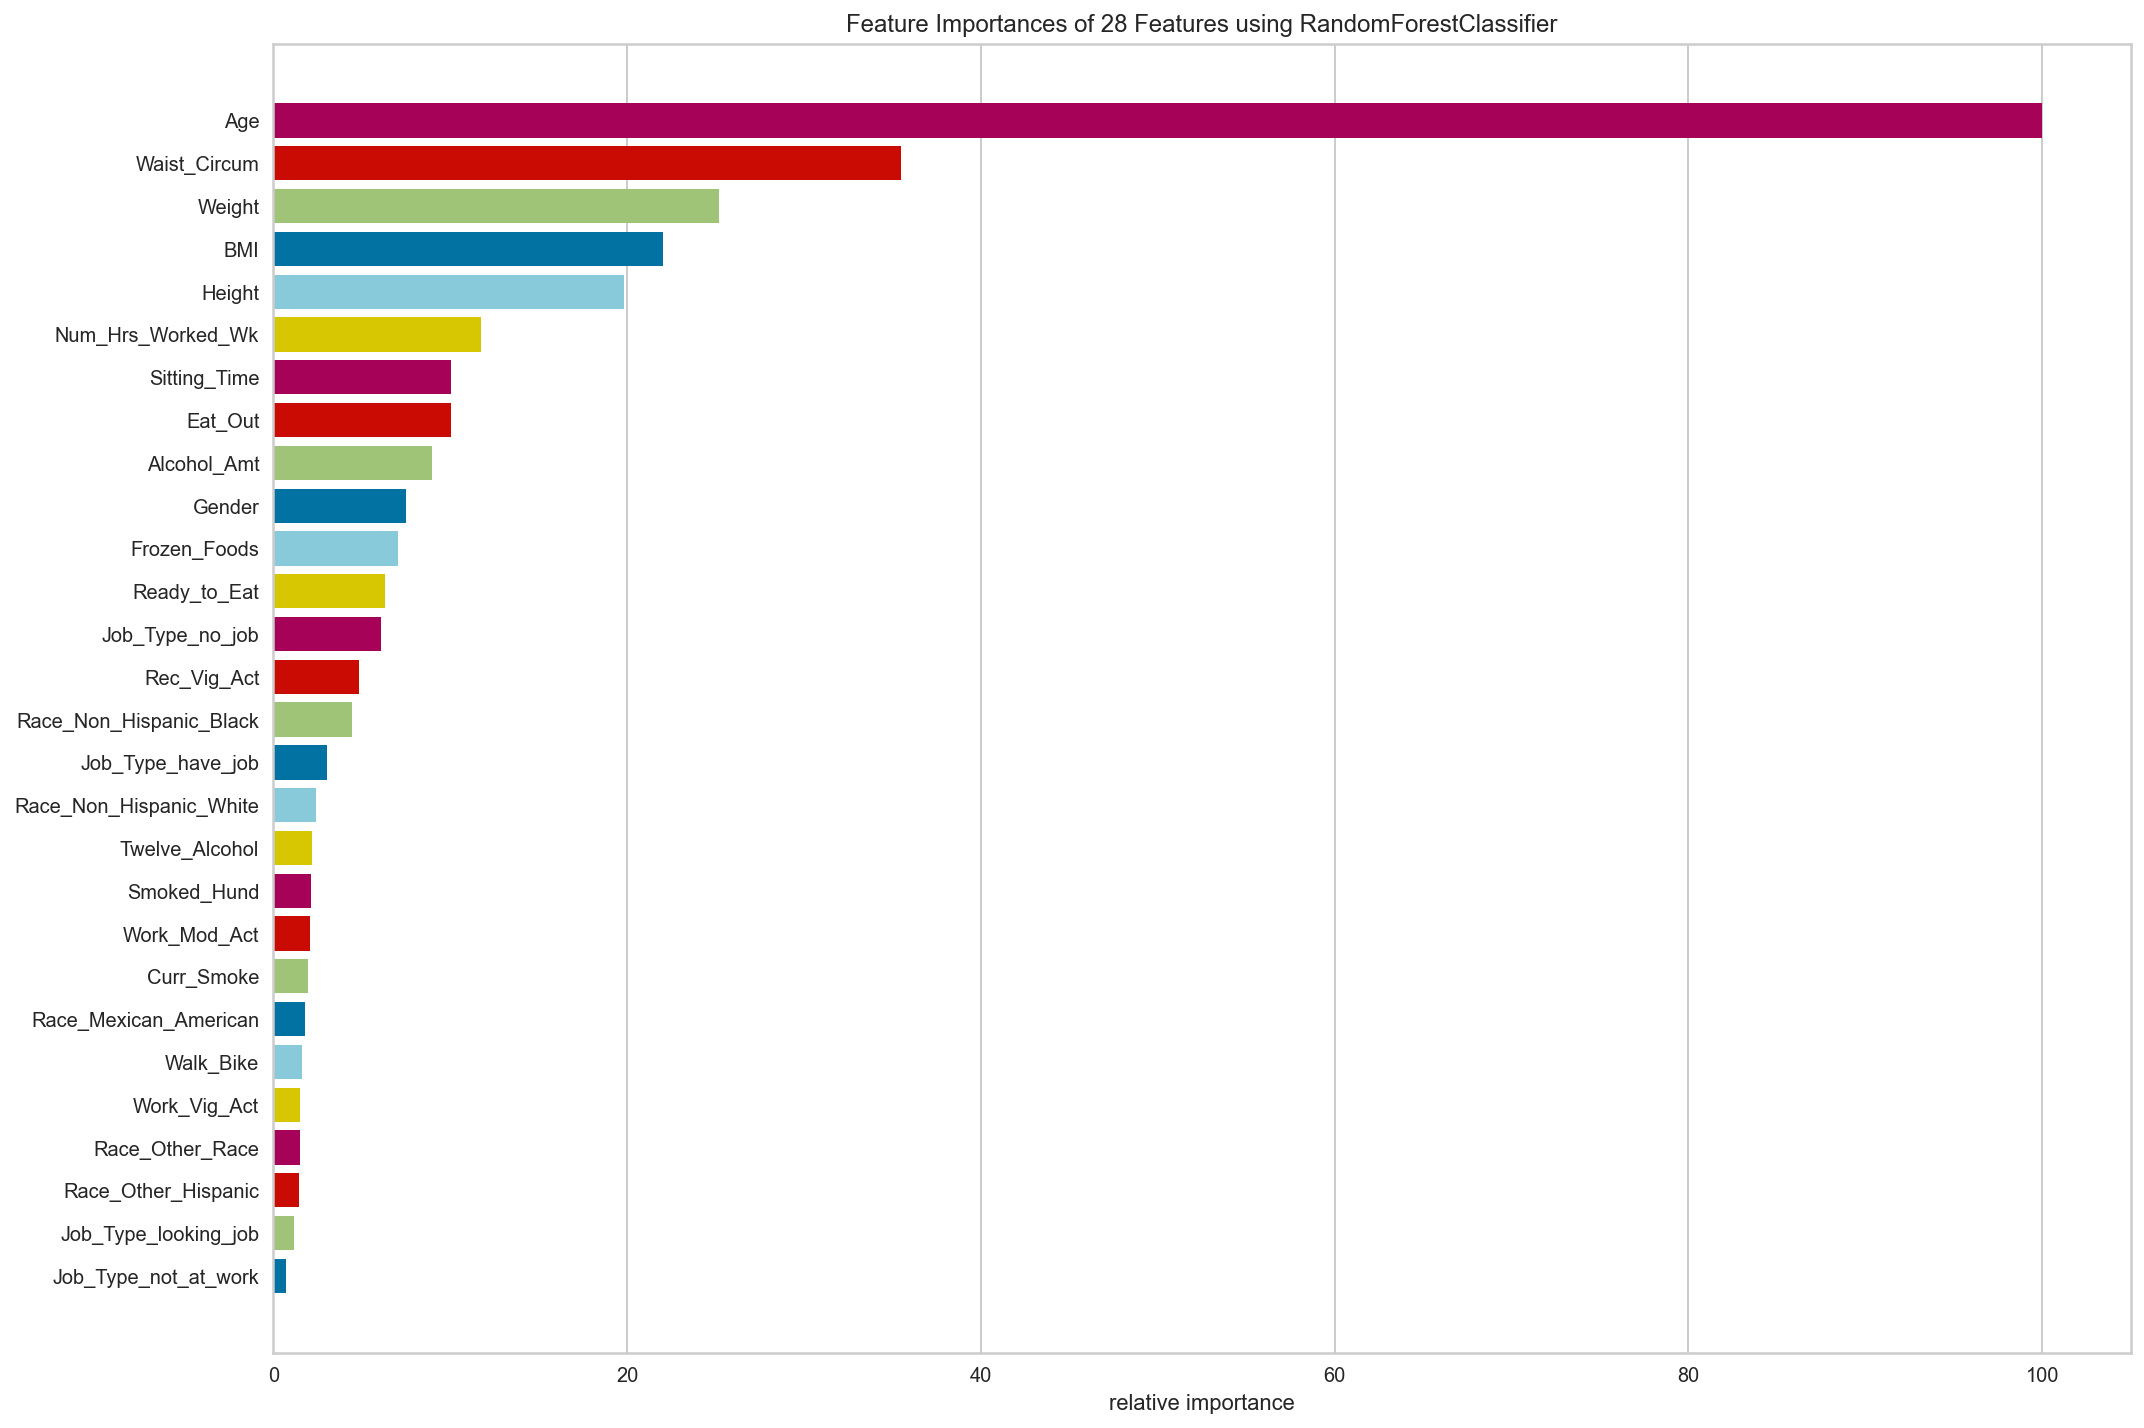

In [173]:
from yellowbrick.features import RadViz

# Import the visualizer
from yellowbrick.features import RadViz

# Instantiate the visualizer using the ``size`` param
visualizer = RadViz(
    classes=['high blood pressure','not high blood pressure'], features=X_train.columns, size=(1080, 720)
)

viz = FeatureImportances(rf2_best)
viz.fit(X_train, y_train)
viz.show();

#### TAKEAWAYS FOR 'ALL FEATURE' RANDOM FOREST
- Can get very slightly better precision and recall score with this model over lm3.  May still want to lm3 for simplicity's sake (e.g. make model easier to read and use by doctors, nurses, etc.), but should dig deeper into how complex this model is to make that call

-</br>
-</br>
### COMPARISON OF MODELS

First, reminder of names for each model that were standouts:
- lm1 = Logistic Regression w/2 features & 0.3 threshold
- lm2 = Logistic Regression w/5 features & 0.23 threshold
- lm3 = Oversampled Logistic Regression w/5 features & 0.34 threshold
- rf1_best = Random Forest after GridSearch w/5 features & 0.24 threshold
- rf2_best = Random Forest after GridSearch w/all 28 features & 0.24 threshold

Now a summary of key metrics for all models considered >

#### Recall (main target metric)

In [174]:
print(f'lm1: {recall_score(y_test, y_pred_lm1_thres3)}')
print(f'lm2: {recall_score(y_test, y_pred_lm2_thres23)}')
print(f'lm3: {recall_score(y_test, y_pred_lm3_thres34)}')
print(f'rf1_best: {recall_score(y_test, y_pred_rf1_best_thres24)}')
print(f'rf2_best: {recall_score(y_test, y_pred_rf2_best_thres26)}')

lm1: 0.7695238095238095
lm2: 0.886984126984127
lm3: 0.8990476190476191
rf1_best: 0.8990476190476191
rf2_best: 0.8958730158730158


-
#### Precision

In [175]:
print(f'lm1: {precision_score(y_test, y_pred_lm1_thres3)}')
print(f'lm2: {precision_score(y_test, y_pred_lm2_thres23)}')
print(f'lm3: {precision_score(y_test, y_pred_lm3_thres34)}')
print(f'rf1_best: {precision_score(y_test, y_pred_rf1_best_thres24)}')
print(f'rf2_best: {precision_score(y_test, y_pred_rf2_best_thres26)}')

lm1: 0.4846061575369852
lm2: 0.4580327868852459
lm3: 0.4535554131966688
rf1_best: 0.45472061657032753
rf2_best: 0.45457474226804123


#### Accuracy

In [176]:
print(f'lm1:{lm1.score(X_test_scaled_v1, y_test)}')
print(f'lm2:{lm2.score(X_test_scaled_v2, y_test)}')
print(f'lm3:{lm3.score(X_test_scaled_v2, y_test)}')
print(f'rf1_best:{rf1_best.score(X_test_scaled_v2, y_test)}')
print(f'rf2_best:{rf2_best.score(X_test, y_test)}')


lm1:0.6725978647686833
lm2:0.6728202846975089
lm3:0.6643683274021353
rf1_best:0.6496886120996441
rf2_best:0.6799377224199288


-
#### F1

In [177]:
print(f'lm1: {f1_score(y_test, y_pred_lm1_thres3)}')
print(f'lm2: {f1_score(y_test, y_pred_lm2_thres23)}')
print(f'lm3: {f1_score(y_test, y_pred_lm3_thres34)}')
print(f'rf1_best: {f1_score(y_test, y_pred_rf1_best_thres24)}')
print(f'rf2_best: {f1_score(y_test, y_pred_rf2_best_thres24)}')

lm1: 0.5947006869479882
lm2: 0.6041081081081081
lm3: 0.6029380455609964
rf1_best: 0.6039667306461932
rf2_best: 0.6031203248557384


-
#### ROC AUC SCORE

In [178]:
print("lm1 model = ", roc_auc_score(y_test, predict_prob_lm1[:,1]))
print("lm2 model = ", roc_auc_score(y_test, predict_prob_lm2[:,1]))
print("lm3 model = ", roc_auc_score(y_test, predict_prob_lm3[:,1]))
print("rf1_best model = ", roc_auc_score(y_test, predict_prob_rf1_best[:,1]))
print("rf2_best model = ", roc_auc_score(y_test, predict_prob_rf2_best[:,1]))

lm1 model =  0.713973362025399
lm2 model =  0.7203629981034979
lm3 model =  0.7204279899795135
rf1_best model =  0.7284384017215239
rf2_best model =  0.7310840492764491


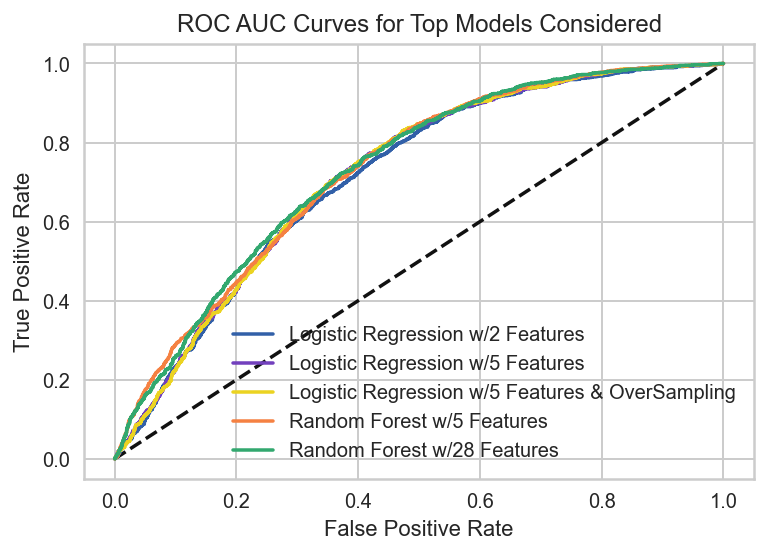

In [179]:
# Plot all models' ROC

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_lm1, tpr_lm1,
         label= "Logistic Regression w/2 Features",
         color='#3260a8')
plt.plot(fpr_lm2, tpr_lm2, 
         label= "Logistic Regression w/5 Features",
         color='#7240bd')
plt.plot(fpr_lm3, tpr_lm3, 
         label= "Logistic Regression w/5 Features & OverSampling",
         color='#ebd321')
plt.plot(fpr_rf1_best, tpr_rf1_best,
         label= 'Random Forest w/5 Features',
         color='#f58142')
plt.plot(fpr_rf2_best, tpr_rf2_best, 
         label= "Random Forest w/28 Features", 
         color='#32a86f')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC AUC Curves for Top Models Considered')
plt.show()

In [ ]:
y_pred_lm3_thres34 = (lm3.predict_proba(X_test_scaled_v2)[:,1] > 0.34)

In [190]:
predicted_probs_lm3 = pd.DataFrame(predict_prob_lm3)

In [191]:
predicted_probs_lm3.head()

0         1
0  0.253561  0.746439
1  0.650731  0.349269
2  0.375157  0.624843
3  0.671906  0.328094
4  0.265750  0.734250

In [211]:
X_test_copy.reset_index(inplace=True)

In [213]:
del X_test_copy['index']

In [214]:
X_test_copy

BMI  Waist_Circum  Height  Weight  Eat_Out  Ready_to_Eat  \
0     28.65         110.0   170.1    82.9      3.0           0.0   
1     41.80         125.3   178.3   132.9     15.0           2.0   
2     32.00         114.1   183.5   107.6      1.0           0.0   
3     31.45          88.6   153.6    74.2      1.0           0.0   
4     26.09         104.2   189.0    93.2      0.0           0.0   
...     ...           ...     ...     ...      ...           ...   
4491  30.19          95.7   150.2    68.1      3.0           0.0   
4492  33.82         105.6   157.6    84.0      1.0           1.0   
4493  24.82          89.7   174.4    75.5     10.0           0.0   
4494  25.30         104.8   183.4    85.1      7.0           7.0   
4495  28.82          98.4   169.2    82.5      5.0           0.0   

      Frozen_Foods  Smoked_Hund  Curr_Smoke  Work_Vig_Act  ...  \
0              1.0          1.0         1.0           0.0  ...   
1              4.0          0.0         0.0           0.0  ...   
2              0.0          1.0         0.0           0.0  ...   
3              5.0          0.0         0.0           0.0  ...   
4              0.0          0.0         0.0           0.0  ...   
...            ...          ...         ...           ...  ...   
4491          12.0          1.0         1.0           1.0  ...   
4492           1.0          0.0         0.0           0.0  ...   
4493           0.0          0.0         0.0           0.0  ...   
4494           0.0          0.0         0.0           1.0  ...   
4495           2.0          0.0         0.0           1.0  ...   

      Num_Hrs_Worked_Wk  Race_Mexican_American  Race_Non_Hispanic_Black  \
0                   0.0                      0                        0   
1                   0.0                      0                        0   
2                  52.0                      0                        0   
3                  46.0                      0                        0   
4                   0.0                      0                        1   
...                 ...                    ...                      ...   
4491               55.0                      1                        0   
4492               40.0                      0                        0   
4493               40.0                      0                        0   
4494               72.0                      0                        0   
4495               36.0                      0                        0   

      Race_Non_Hispanic_White  Race_Other_Hispanic  Race_Other_Race  \
0                           1                    0                0   
1                           1                    0                0   
2                           1                    0                0   
3                           1                    0                0   
4                           0                    0                0   
...                       ...                  ...              ...   
4491                        0                    0                0   
4492                        0                    0                1   
4493                        0                    1                0   
4494                        1                    0                0   
4495                        1                    0                0   

      Job_Type_have_job  Job_Type_looking_job  Job_Type_no_job  \
0                     0                     0                1   
1                     0                     0                1   
2                     1                     0                0   
3                     1                     0                0   
4                     0                     0                1   
...                 ...                   ...              ...   
4491                  1                     0                0   
4492                  1                     0                0   
4493                  1                     0     

In [198]:
X_test_for_analysis_v2

In [194]:
X_test_for_analysis = X_test.reset_index(inplace=True)

In [196]:
X_test_for_analysis

In [228]:
test_probs_lm3 = X_test_copy.join(predicted_probs_lm3)

In [221]:
y_test_copy = y_test.reset_index()

In [224]:
del y_test_copy['index']

In [229]:
full_test_model_data_lm3 = test_probs_lm3.join(y_test_copy)

In [236]:
full_test_model_data_lm3.rename(columns={0:'Not_High_BP_Prob',1:'High_BP_Prob'}, inplace=True)

In [238]:
full_test_model_data_lm3.to_csv('data/csv/test_model_data_lm3.csv')

In [243]:
X_train_v2.head()

Age  Weight  Alcohol_Amt  Race_Non_Hispanic_Black  Curr_Smoke
20515  63.0   153.6          1.0                        1         0.0
16990  47.0    75.0          1.0                        1         0.0
21904  62.0    65.1          0.0                        0         0.0
818    80.0    67.4          1.0                        0         0.0
21776  63.0   103.0          0.0                        1         0.0

In [ ]:
X_train_scaled_v2 = std_scale.fit_transform(X_train_v2)
X_val_scaled_v2 = std_scale.fit_transform(X_val_v2)
X_test_scaled_v2 = std_scale.fit_transform(X_test_v2)

In [242]:
pd.DataFrame(X_train_scaled_v2)

0         1         2         3         4
0      0.804405  3.447639 -0.368994  1.968123 -0.507174
1     -0.081956 -0.299931 -0.368994  1.968123 -0.507174
2      0.749008 -0.771954 -0.765257 -0.508098 -0.507174
3      1.746164 -0.662292 -0.368994 -0.508098 -0.507174
4      0.804405  1.035081 -0.765257  1.968123 -0.507174
...         ...       ...       ...       ...       ...
13480  0.859803  0.400950 -0.368994 -0.508098 -0.507174
13481  0.028839 -0.791025 -0.765257 -0.508098 -0.507174
13482 -1.522294 -0.638452  0.027270  1.968123 -0.507174
13483 -0.635932  1.516639 -0.368994  1.968123 -0.507174
13484 -0.968318 -0.757650  0.027270 -0.508098  1.971710

[13485 rows x 5 columns]